# OSM PreProcessing and Clustering

This notebook is divided into a number of sections with main headers:

1. Reading and cleaning OSM data
    
2. Transformation and standardisation
    
3. Dimensionality reduction
    
4. Clustering and optimisation
    
5. Definition of final model clusters
    
6. Analysis of cluster characteristics using OSM features
    
7. Analysis of cluster characteristics using external SEDC features
    
8. Generalised Linear Models for a representative OSM amenity type

## 1. Reading and cleaning OSM data

In [1]:
# Package imports and reading OpenStreeMaps data from DataCollection script
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy.stats as st
from kneed import KneeLocator

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LinearRegression, TheilSenRegressor, LogisticRegression, PoissonRegressor, Ridge, Lasso

sns.set_palette("tab10")
sns.set_style("whitegrid")
plt.style.use('seaborn-whitegrid')
plt.set_cmap("tab10")
default_c = plt.cm.get_cmap('Set1')(0.2)

df1 = pd.read_csv('outputs/output_270522.csv')
df2 = pd.read_csv('outputs/leisure_output_21062022.csv')

<Figure size 432x288 with 0 Axes>

### Exploring amenity counts

- Reading collected OSM data for amenity counts
- Comprised of two files given different keys (mainly "amenity" features with a few "leisure")

#### Prevalence of zero values

In [2]:
# joining on leisure node counts
df = df1.join(df2[['park_count', 'fitness_station']])

# renaming for consistency
df = df.rename(columns={'fitness_station':'fitness_station_count'})

# prevalence of zeros
amenities = ['recycling_count', 'social_centre_count',
       'bicycle_repair_station_count', 'language_school_count',
       'waste_basket_count', 'bicycle_parking_count', 'waste_disposal_count',
       'charging_station_count', 'public_bookcase_count', 'library_count',
       'social_facility_count', 'community_centre_count', 'bus_station_count',
       'childcare_count', 'park_count', 'fitness_station_count']

zero_counts = {}
for i in amenities:
    zero_counts[i] = df[df[i]==0].shape[0]

pd.DataFrame().from_dict(zero_counts, orient='index', columns=['count']).sort_values('count', ascending=False).rename(columns={'count':'Number of cities (of 200) with count of zero'})

Number of cities (of 200) with count of zero
language_school_count                                                  176
social_centre_count                                                    121
fitness_station_count                                                  112
public_bookcase_count                                                   98
bus_station_count                                                       83
childcare_count                                                         76
community_centre_count                                                  66
recycling_count                                                         56
social_facility_count                                                   53
waste_disposal_count                                                    52
bicycle_repair_station_count                                            46
charging_station_count                                                  30
library_count                                                           24
bicycle_parking_count                                                   22
waste_basket_count                                                      19
park_count                                                               9

#### Count of non-zero OSM features for cities

While several of the OSM features have a high prevalence of samples with inflated zero counts, the histogram below demonstrates that most cities have 10 or more OSM features with data (i.e. with counts of > 0).

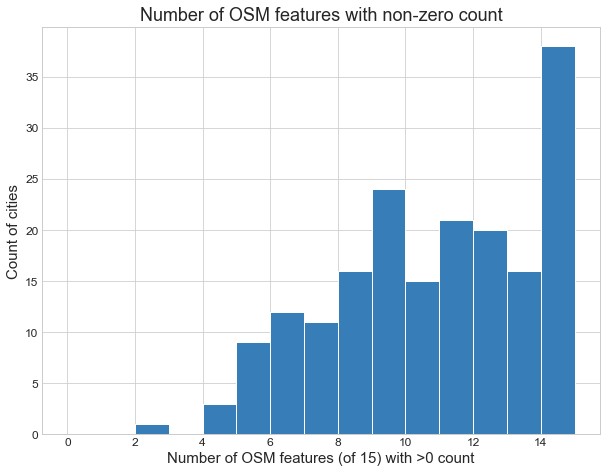

In [3]:
(df[amenities]>0).sum(axis=1).sort_values().hist(bins=np.arange(0, 16,1),
                                                 figsize=(10,7.5),
                                                 color=default_c)
plt.title('Number of OSM features with non-zero count', fontsize=18)
plt.ylabel('Count of cities', fontsize=15)
plt.xlabel('Number of OSM features (of 15) with >0 count', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('hist_cities_OSM_non_zero.png', dpi=400, bbox_inches='tight')

#### Average count of amenity nodes per city

<ipython-input-4-5f7a433c7017>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.mean()[amenities].sort_values().sort_values().plot(kind='bar', figsize=(10,7.5), color=default_c)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

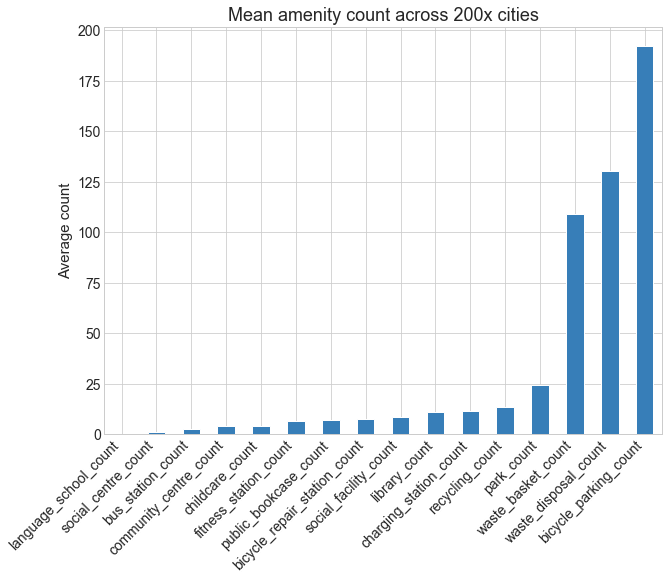

In [4]:
## Mean amenity count per city
lowest = [i for i in df[amenities].sum(axis=1).sort_values().head().index]
df[df.index.isin(lowest)][amenities]
df.mean()[amenities].sort_values().sort_values().plot(kind='bar', figsize=(10,7.5), color=default_c)
plt.title('Mean amenity count across 200x cities', fontsize=18)
plt.ylabel('Average count', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

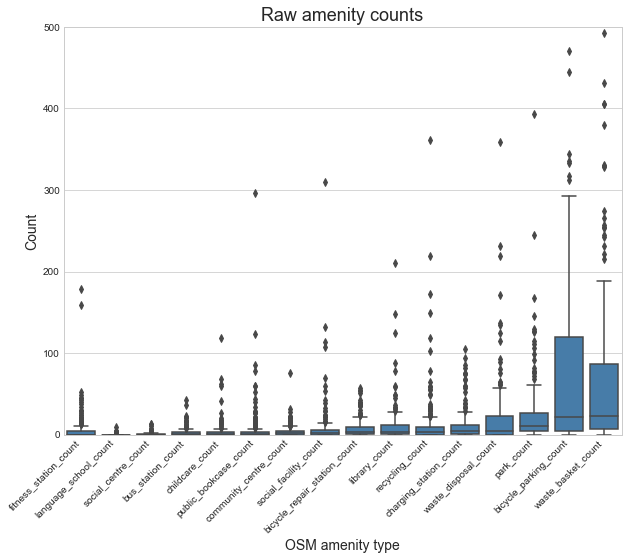

In [5]:
# Distribtution of amenity counts per city
melted = df[amenities].melt()
order = [i for i in melted.groupby('variable').median().sort_values('value').index]
plt.figure(figsize=(10,7.5))
sns.boxplot(x='variable', y='value', data=melted,
           order=order, color=default_c)
plt.ylim((0,500))
plt.xlabel('OSM amenity type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Raw amenity counts', fontsize=18)
plt.xticks(rotation=45, ha='right')

Text(0.5, 0, 'Sum of amenity counts')

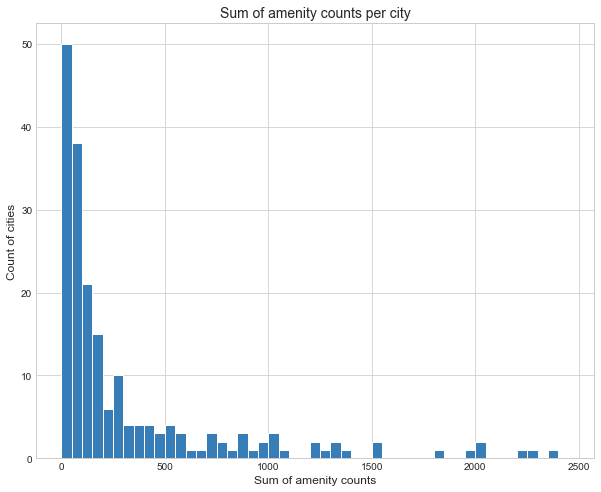

In [6]:
## Dropping columns with no value, all zeros)
#df = df.drop(columns=['Unnamed: 0', 'libary_count', 'charging_point_count'])

## Distribution of total amenity count per city
df[['recycling_count', 'social_centre_count',
       'bicycle_repair_station_count', 'language_school_count',
       'waste_basket_count', 'bicycle_parking_count', 'waste_disposal_count',
       'charging_station_count', 'public_bookcase_count', 'library_count',
       'social_facility_count', 'community_centre_count', 'bus_station_count',
       'childcare_count', 'park_count', 'fitness_station_count']].sum(axis=1).sort_values().hist(bins=np.arange(0,2500,50), figsize=(10,8), color=default_c)

plt.title('Sum of amenity counts per city', fontsize=14)
plt.ylabel('Count of cities',  fontsize=12)
plt.xlabel('Sum of amenity counts', fontsize=12)

### Calculating OSM normalised features

- "Normalising" in this preprocessing step refers to taking the raw amenity count values and calculating an intensity value. T
Two main options have been explored:
    - Amenity count per million population (or 'per capita')
    - Amentiy count per 10 square kilometres (or 'per unit area')

In [7]:
# amenities per capita
for i in amenities:
    header = str(i)+'_pmn' # per million persons
    df[header] = df[i] / (df['population']/1000000)

amenities_pmn = [str(i+'_pmn') for i in amenities]
df[amenities_pmn].describe()

# amenities per area
for i in amenities:
    header = str(i)+'_psqkm' # per square km
    df[header] = df[i] / (df['area_sqkm']/10)

amenities_psqkm = [str(i+'_psqkm') for i in amenities]
df[amenities_pmn + amenities_psqkm].describe()

recycling_count_pmn  social_centre_count_pmn  \
count           200.000000               200.000000   
mean             11.292501                 0.887694   
std              19.995176                 1.490785   
min               0.000000                 0.000000   
25%               0.000000                 0.000000   
50%               4.398170                 0.000000   
75%              11.412770                 1.470088   
max             128.105093                 8.436896   

       bicycle_repair_station_count_pmn  language_school_count_pmn  \
count                        200.000000                 200.000000   
mean                           9.070859                   0.099103   
std                           14.016016                   0.373624   
min                            0.000000                   0.000000   
25%                            1.065125                   0.000000   
50%                            4.819746                   0.000000   
75%                           11.520942                   0.000000   
max                          114.031459                   3.657123   

       waste_basket_count_pmn  bicycle_parking_count_pmn  \
count              200.000000                 200.000000   
mean                96.296908                 129.836198   
std                148.894610                 234.503239   
min                  0.000000                   0.000000   
25%                 14.079382                  10.601111   
50%                 40.064833                  39.292030   
75%                104.275250                 141.795745   
max                944.257587                1899.483076   

       waste_disposal_count_pmn  charging_station_count_pmn  \
count                200.000000                  200.000000   
mean                 153.338734                   14.000706   
std                  745.257264                   24.717583   
min                    0.000000                    0.000000   
25%                    0.000000                    2.845990   
50%                    6.264071                    6.023071   
75%                   33.091110                   15.454371   
max                 6672.451571                  244.701588   

       public_bookcase_count_pmn  library_count_pmn  ...  \
count                 200.000000         200.000000  ...   
mean                    6.260692           9.676223  ...   
std                    15.932316          11.195854  ...   
min                     0.000000           0.000000  ...   
25%                     0.000000           3.181814  ...   
50%                     0.612608           6.372949  ...   
75%                     4.186652          12.740800  ...   
max                   129.829663          72.801312  ...   

       waste_disposal_count_psqkm  charging_station_count_psqkm  \
count                  200.000000                    200.000000   
mean                     2.060840                      0.218805   
std                     10.746869                      0.394721   
min                      0.000000                      0.000000   
25%                      0.000000                      0.027121   
50%                      0.109336                      0.081428   
75%                      0.372694                      0.251783   
max                    105.558184                      3.213318   

       public_bookcase_count_psqkm  library_count_psqkm  \
count                   200.000000           200.000000   
mean                      0.135160             0.189841   
std                       0.412948             0.356272   
min                       0.000000             0.000000   
25%                       0.000000             0.034155   
50%                       0.005727             0.084194   
75%                       0.070236             0.182364   
max                       3.277620             3.044196   

       social_facility_count_psqkm  community_centre_count_psqkm  \
count                   20

Text(0.5, 0, 'Sum of amenity counts')

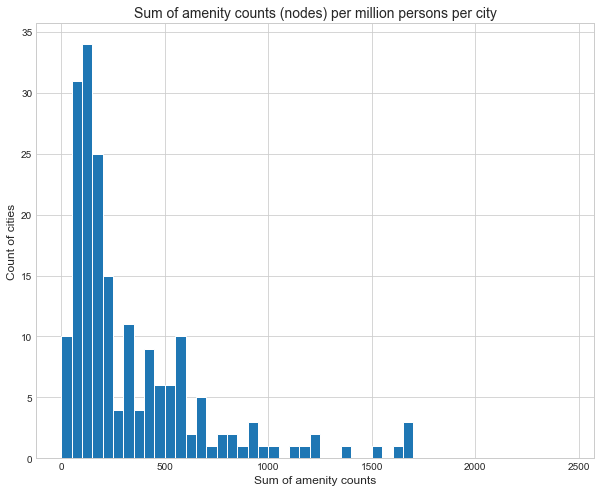

In [8]:
# Total amenity (node) count per million persons
(df[amenities].sum(axis=1) / (df['population']/1000000)).hist(bins=np.arange(0,2500,50), figsize=(10,8))
plt.title('Sum of amenity counts (nodes) per million persons per city', fontsize=14)
plt.ylabel('Count of cities',  fontsize=12)
plt.xlabel('Sum of amenity counts', fontsize=12)

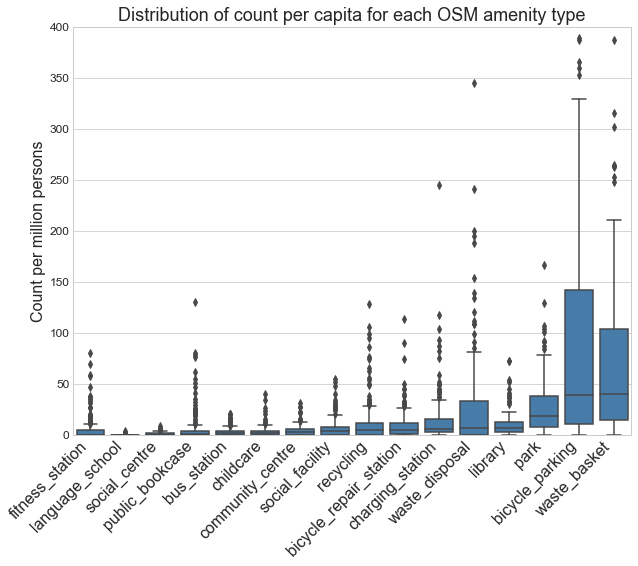

In [9]:
# Distribtution of amenity count per person by amenity type
melted = df[amenities_pmn].melt()
melted['variable'] = melted['variable'].str.replace('_count_pmn', '')
order = [i for i in melted.groupby('variable').median().sort_values('value').index]
plt.figure(figsize=(10,7.5))
sns.boxplot(x='variable', y='value', data=melted,
           order=order, color=default_c)
plt.ylim((0,400))
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.title('Distribution of count per capita for each OSM amenity type', fontsize=18)
plt.xlabel('')
plt.ylabel('Count per million persons', fontsize=16)
plt.yticks(fontsize=12)
plt.savefig('boxplot_OSM_count_pmn.png', dpi=400, bbox_inches='tight')

### Treating erroneous values

Outliers were found in 6x cities for amenity=waste_disposal through exploratory analysis. These are considered erroneous values given they are concentrated in one unlikely state (AZ with very low population density). These values were assigned the median value from across the population for this feature. The median was imputed rather than assigning a value at the top end of the probability distribution (windsorising) because the values are considered to be erroneous and misleading, but the 6x samples were not removed from the dataset to ensure a maximum possible sample size.

In [10]:
## Windsorizing 6x samples with waste_disposal pmn of >3k with the median
impute_val = df[df['waste_disposal_count_pmn'] < 3000]['waste_disposal_count_pmn'].median()
df['waste_disposal_count_pmn'] = np.where(df['waste_disposal_count_pmn']>3000, impute_val, df['waste_disposal_count_pmn'])
df[amenities_pmn].describe()

recycling_count_pmn  social_centre_count_pmn  \
count           200.000000               200.000000   
mean             11.292501                 0.887694   
std              19.995176                 1.490785   
min               0.000000                 0.000000   
25%               0.000000                 0.000000   
50%               4.398170                 0.000000   
75%              11.412770                 1.470088   
max             128.105093                 8.436896   

       bicycle_repair_station_count_pmn  language_school_count_pmn  \
count                        200.000000                 200.000000   
mean                           9.070859                   0.099103   
std                           14.016016                   0.373624   
min                            0.000000                   0.000000   
25%                            1.065125                   0.000000   
50%                            4.819746                   0.000000   
75%                           11.520942                   0.000000   
max                          114.031459                   3.657123   

       waste_basket_count_pmn  bicycle_parking_count_pmn  \
count              200.000000                 200.000000   
mean                96.296908                 129.836198   
std                148.894610                 234.503239   
min                  0.000000                   0.000000   
25%                 14.079382                  10.601111   
50%                 40.064833                  39.292030   
75%                104.275250                 141.795745   
max                944.257587                1899.483076   

       waste_disposal_count_pmn  charging_station_count_pmn  \
count                200.000000                  200.000000   
mean                  27.329094                   14.000706   
std                   62.163653                   24.717583   
min                    0.000000                    0.000000   
25%                    0.000000                    2.845990   
50%                    5.783773                    6.023071   
75%                   26.785712                   15.454371   
max                  623.687745                  244.701588   

       public_bookcase_count_pmn  library_count_pmn  \
count                 200.000000         200.000000   
mean                    6.260692           9.676223   
std                    15.932316          11.195854   
min                     0.000000           0.000000   
25%                     0.000000           3.181814   
50%                     0.612608           6.372949   
75%                     4.186652          12.740800   
max                   129.829663          72.801312   

       social_facility_count_pmn  community_centre_count_pmn  \
count                 200.000000                  200.000000   
mean                    6.275415                    3.967819   
std                     9.107996                    5.266940   
min                     0.000000                    0.000000   
25%                     0.000000                    0.000000   
50%                     3.326413                    2.463302   
75%                     7.985587                    5.281576   
max                    54.874055                   30.933033   

       bus_station_count_pmn  childcare_count_pmn  park_count_pmn  \
count             200.000000           200.000000      200.000000   
mean                2.652955             3.222097       26.710187   
std                 3.961685             5.227133       26.354416   
min                 0.000000             0.000000        0.000000   
25%                 0.000000             0.000000        7.481413   
50%                 1.352259             1.962197       18.728038   
75%                 3.564301             4.147719       37.989866   
max                20.598001            39.763919      166.217526   

       fitness_station_count_pmn  
count                 200.000000  
mean  

The observation below justified removing 'language_school' from the analysis

In [11]:
## Summing up feature count pmn -- get rid of language school?
df[amenities_pmn].sum().sort_values()

language_school_count_pmn              19.820628
social_centre_count_pmn               177.538797
bus_station_count_pmn                 530.590951
childcare_count_pmn                   644.419468
community_centre_count_pmn            793.563783
public_bookcase_count_pmn            1252.138400
social_facility_count_pmn            1255.082996
fitness_station_count_pmn            1696.682436
bicycle_repair_station_count_pmn     1814.171887
library_count_pmn                    1935.244601
recycling_count_pmn                  2258.500170
charging_station_count_pmn           2800.141219
park_count_pmn                       5342.037308
waste_disposal_count_pmn             5465.818721
waste_basket_count_pmn              19259.381546
bicycle_parking_count_pmn           25967.239643
dtype: float64

## 2. Transformation & Standardisation

- The "raw" values are the amenity counts while the "normalised" values are the amenity counts per million population
- These variables are then subject to preprocessing steps of transformation and standardisation

**Transformation**
- The normalised OSM features typically exhibit a strong right-tail skew, often with a high prevalence of zero values
- Transformations can potentially improve the value of these features
- In some cases the normalised OSM features are log-normal (logarithm resembles normal distribution)
- Also explored is a quantile-based transformation which sacrificies a log information from the continuous distribution but was worth exploring based on the imperfect nature of OSM data and the desire to compare cities on a relative basis

**Standardisation**
- Two methods for the final standardisation of values were explored
    - Standardisation ((x-mean)/(stdev))
    - Robust Scaler ((x-median)/(IQR))

In [12]:
def preprocess(X, transform=None, scaler='sc', print_log=False):
    """Preprocess dataset
       X = pandas dataframe of features & samples
       Outputs preprocessed numpy array
       Transform defines statistical transformation of raw values
           'sqrt' = Square root
           'cbrt' = Cube root
           'log' =  Natural logarithm
           'log10' = Log to the base 10
           'decile' = Decile integer
       Scaler defines choice of standardisation technique
           'sc' = StandardScaler, ie z-score
           'rsc' = RobustScaler, ie ((x-median)/IQR)"""
    
    X = X.values
    
    if len(X.shape) == 1:
        X = X.reshape(-1,1)

    if transform == 'sqrt':
        X = np.sqrt(X+1)
    
    if transform == 'cbrt':
        X = np.cbrt(X+1)
    
    if transform == 'log':
        X = np.log(X+1)
        
    if transform == 'log10':
        X = np.log10(X+1)
        
    if transform == 'decile':
        X = pd.DataFrame(X).rank() / X.shape[0]
        X = round(X*10,0).values
    
    if scaler =='sc':
        scaler = preprocessing.StandardScaler().fit(X)
        X = scaler.transform(X)
        
    elif scaler == 'rsc':
        scaler = preprocessing.RobustScaler().fit(X)
        X = scaler.transform(X)
        
    if print_log == True:
        print("Scaler: ", str(scaler))
        print("Transform: ", str(transform))
        print("Shape of preprocessed dataset: ", X.shape)

    return X
    
preprocess(df[amenities_pmn], transform='log10', scaler='sc')

array([[ 0.51489974,  0.17660189, -0.83700401, ...,  1.094781  ,
         0.2342318 , -0.0105531 ],
       [-0.34005543, -0.15188039, -0.21779732, ..., -0.70482231,
        -0.74651046,  0.57695105],
       [-0.27021417,  0.83323188, -0.14795112, ...,  0.1198175 ,
        -1.0518236 , -0.72760382],
       ...,
       [ 0.45202575,  3.04462115, -1.44034873, ...,  1.37264485,
        -2.55870604, -0.72760382],
       [ 0.00373056, -0.70445863, -0.01206505, ...,  0.7368681 ,
         0.05361966, -0.72760382],
       [ 1.54737469, -0.70445863, -0.00858542, ..., -1.06395342,
        -2.55870604, -0.72760382]])

#### Comparing transformations

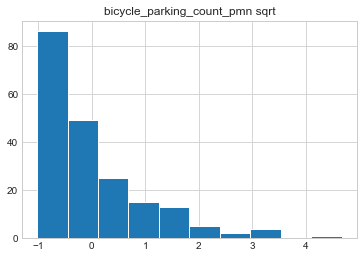

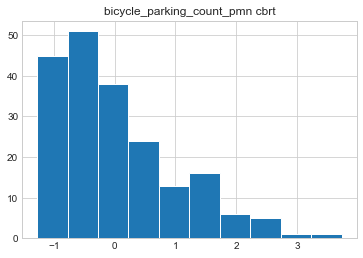

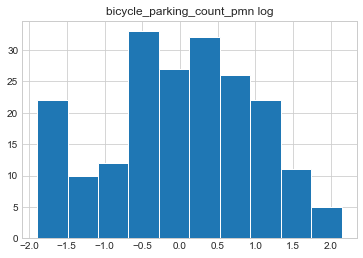

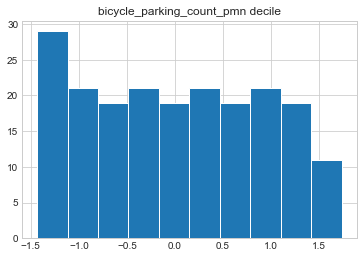

In [13]:
# Assessing influence of transformation on feature distribution
transforms = ['sqrt', 'cbrt', 'log', 'decile']
amenity = 'bicycle_parking_count_pmn'

for i in transforms:
    X_sc = preprocess(df[amenity], transform=i, scaler='sc')
    pd.DataFrame(X_sc).hist()
    plt.title(amenity+' '+i)
    plt.show()

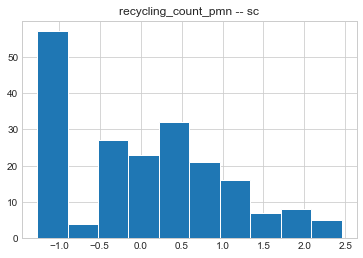

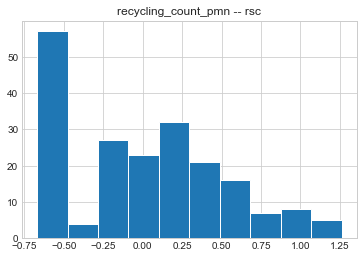

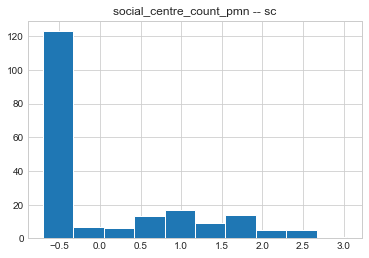

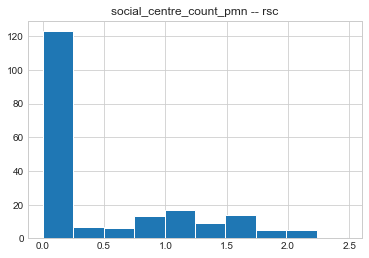

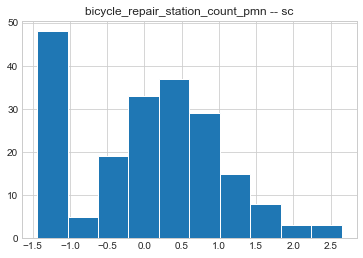

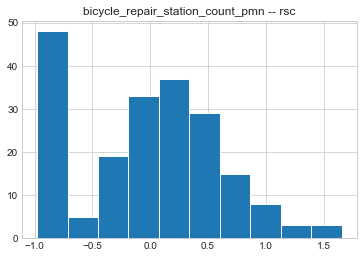

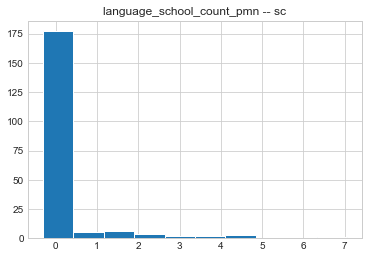

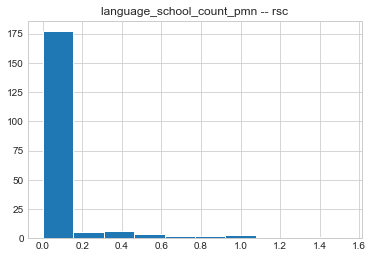

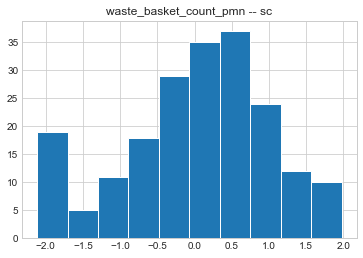

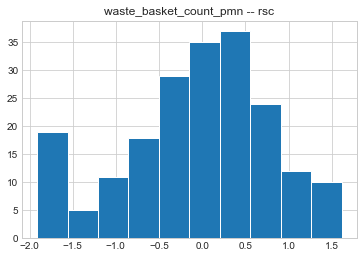

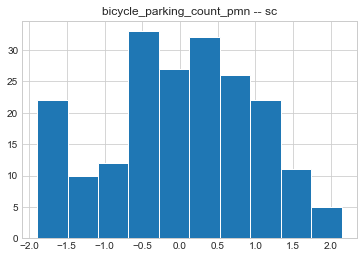

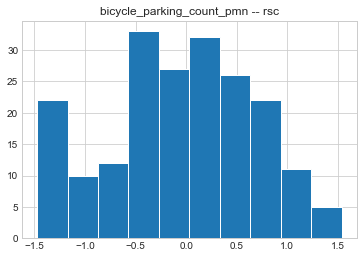

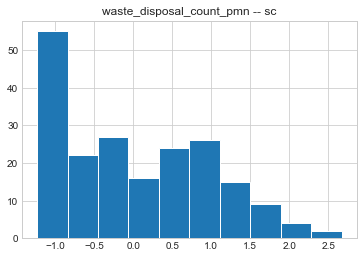

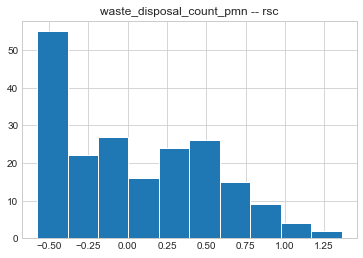

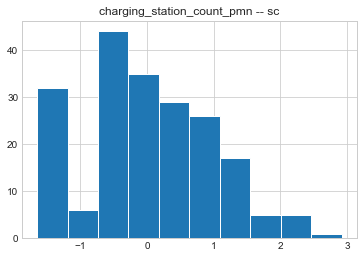

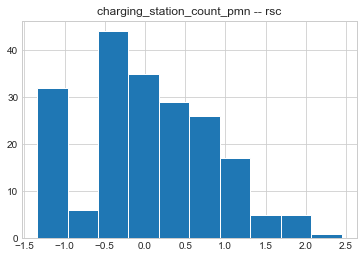

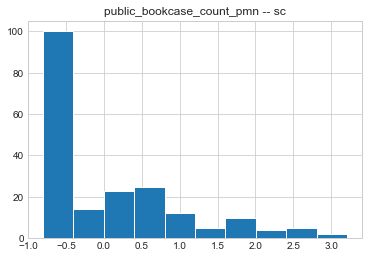

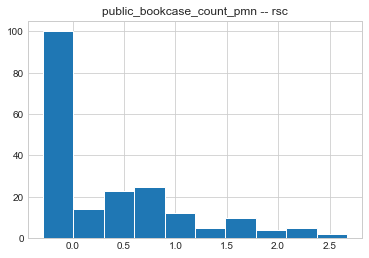

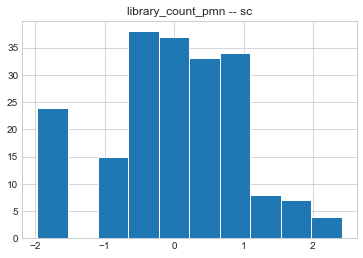

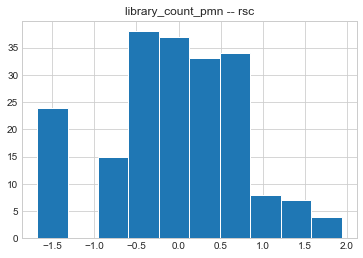

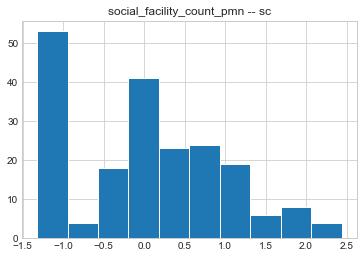

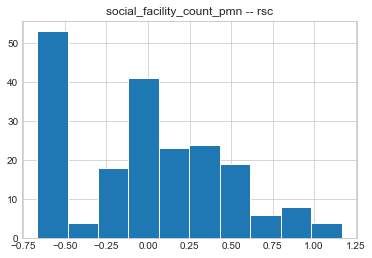

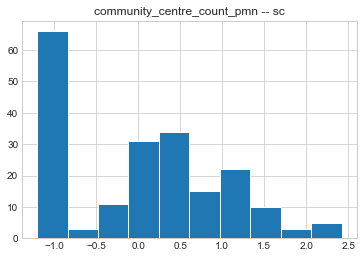

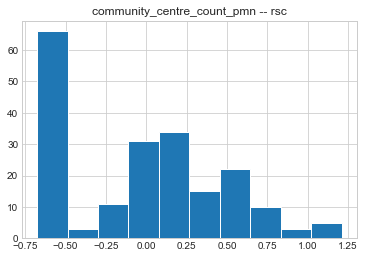

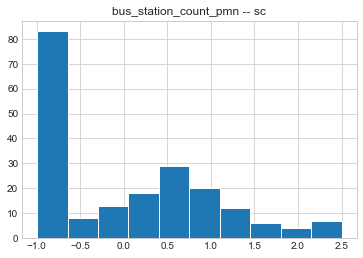

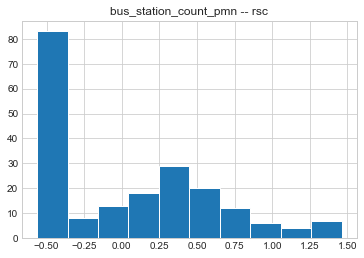

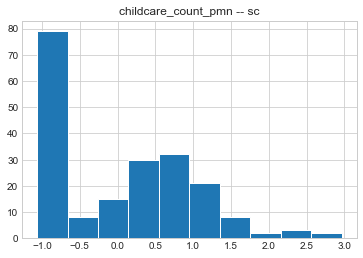

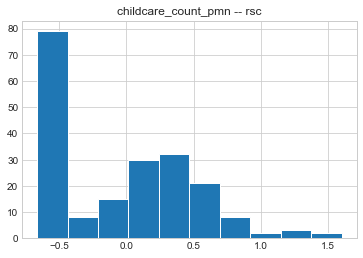

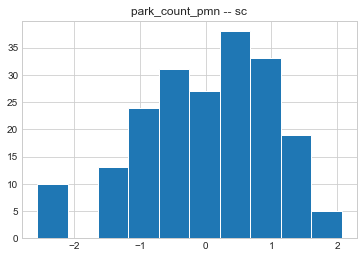

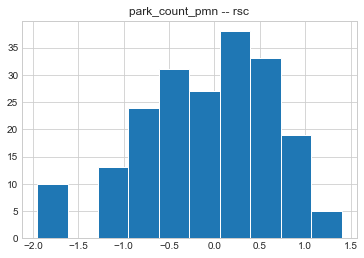

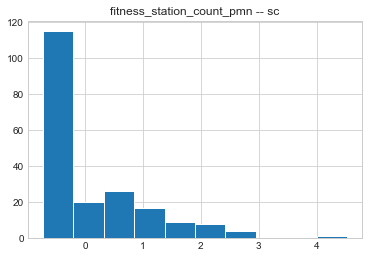

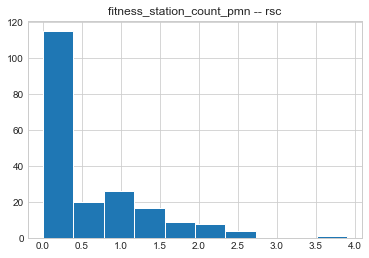

In [14]:
# Assessing influence of scaler on feature distribution
# Negligble influence on distribution from choice of scaler
X_sc = preprocess(df[amenities_pmn], transform='log', scaler='sc')
X_rsc = preprocess(df[amenities_pmn], transform='log', scaler='rsc')
X_sc_df = pd.DataFrame(X_sc)
X_rsc_df = pd.DataFrame(X_rsc)
X_sc_df
for i in range(len(X_sc_df.columns)):
    col = amenities_pmn[i]
    
    X_sc_df.iloc[:,i].hist()
    plt.title(amenities_pmn[i]+' -- sc')
    plt.show()
    
    X_rsc_df.iloc[:,i].hist()
    plt.title(amenities_pmn[i]+' -- rsc')
    plt.show()

#### Correlations of normalised amenity counts across all OSM features

There are several instances where a notable correlation exists between normalised OSM features.

The pair of amenity types 'bicycle_parking' and 'waste_basket' display the highest correlation, although this might be skewed by the relatively high prevalence of these amenity types. However, correlations are also present between amenity types of lower count, for example 'recycling' and 'childcare'.

<Figure size 720x576 with 0 Axes>

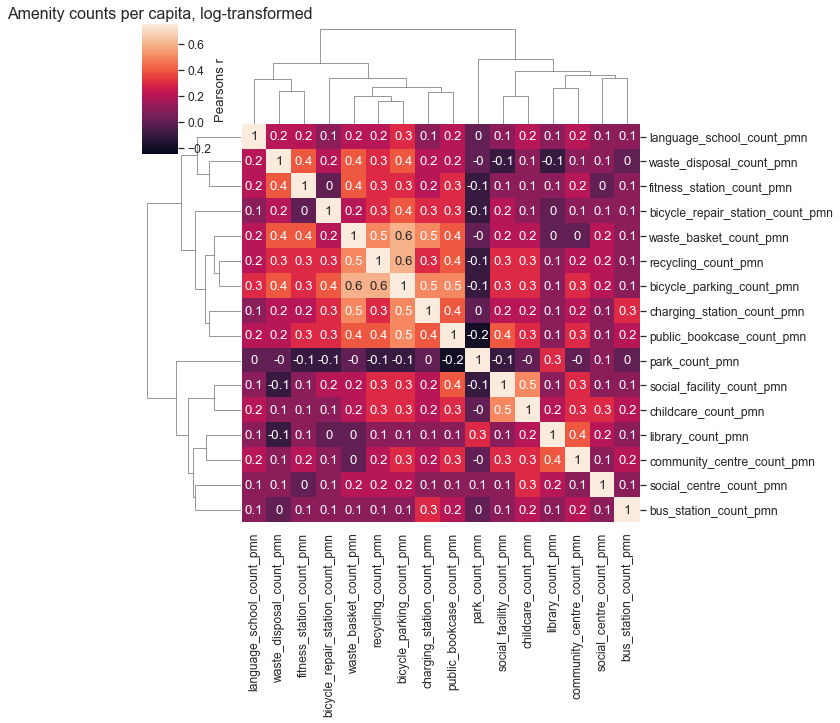

In [15]:
X_sc = preprocess(df[amenities_pmn], transform='log', scaler='sc')
X_sc_df = pd.DataFrame(X_sc)
mapper = {}
for i in range(X_sc_df.shape[1]):
    mapper[i] = amenities_pmn[i]
X_sc_df = X_sc_df.rename(columns=mapper)
sns.set(font_scale=1.1)
plt.figure(figsize=(10,8))
sns.clustermap(round(X_sc_df.corr(), 1),
               annot=True,
               metric="euclidean",
               method="ward",
               #cmap="Blues",
               #standard_scale=1)
              vmin=-0.25, vmax=0.75,
              )
plt.ylabel('Pearsons r')
plt.title('Amenity counts per capita, log-transformed', fontsize=16)
plt.savefig('correl_OSM_count_pmn_log', dpi=400, bbox_inches='tight')

## 3. Dimensionality Reduction

Dimensionality Reduction is an important step in this analysis given that the OSM amenity features are noisy, zero-inflated and prone to biases. There is a need to extract the most valuable information from across the entire feature space. By performing dimensionality reduction prior to clustering helps to ensure that the components of the dataset with the highest variance are retained and thus will offer the best opportunity to discriminate between groups of cities with similar characteristics.

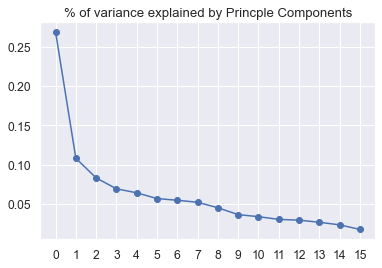

Principle Components retained:  2
Explained variance by 2 PCs:  0.37724188993357216


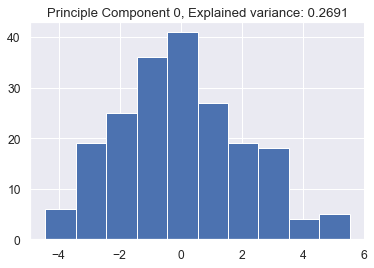

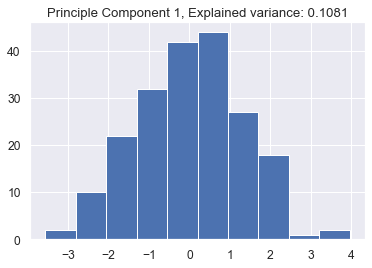

Cumulative variance:
PC 0: 0.2691
PC 1: 0.3772


In [16]:
def pca(X, retain_pcs='knee', print_log=False):
    """Perform principle component analysis on dataset,
    X is input dataset as numpy array,
    n_components = initial n_components to perform PCA,
    Knee package computes n_components to retain according to convex curve of explained variance ratio
    If retain_pcs use Knee package, if int set pcs to retain
    Outputs pandas dataframe of retained PCs"""
    
    # perform PCA
    # create DF of all PCs
    # calculate optimal n pcs with knee
    # print n and cumulative var at n
    # plot histogram of each pc and variance ratio
    # return df of retained PCs
    
    ## Principle Component Analysis
    
    n_components=X.shape[1]
    
    pca = PCA(n_components=n_components).fit(X)
    
    X_pca = pca.transform(X) # reduced feature space: numpy array
    X_pca_df= pd.DataFrame(X_pca) # reduced feature space: dataframe
    
    ## Determining n components to retain
    pc_cum_var = [[], []] # nested list of results
    cum_var = 0 # object to store cumulative variance at n pc
    
    for i in range(len(pca.explained_variance_ratio_)):
        pc_cum_var[0].append(i)
        cum_var += pca.explained_variance_ratio_[i]
        pc_cum_var[1].append(cum_var)
    
    if print_log == True:    
        plt.scatter(x=pc_cum_var[0], y=pca.explained_variance_ratio_)
        plt.plot(pca.explained_variance_ratio_)
        plt.title('% of variance explained by Princple Components')
        plt.xticks(np.arange(0, len(pca.explained_variance_ratio_), 1))
        plt.show()

    kl = KneeLocator(range(n_components),
                     [i for i in pca.explained_variance_ratio_],
                     curve='convex',
                     direction='decreasing')
    if retain_pcs != 'knee':
        n = retain_pcs
    else:
        n = kl.elbow
        
    if print_log == True:
        print("Principle Components retained: ", n)
        print("Explained variance by "+str(n)+" PCs: ", np.sum(pca.explained_variance_ratio_[:n]))
                                     
        for i in range(n):
            X_pca_df.iloc[:,i].hist()
            plt.title("Principle Component "+str(i)+", Explained variance: "+str(round(pca.explained_variance_ratio_[i],4)))
            plt.show()

        cumulative_variance = 0

        print('Cumulative variance:')
        for i in range(len(pca.explained_variance_ratio_[:n])):
            cumulative_variance += pca.explained_variance_ratio_[i]
            print("PC "+str(i)+": "+str(round(cumulative_variance, 4)))
        
#     return X_pca_df.iloc[:,:n]
    return X_pca[:,:n]

X_pca = pca(X_sc, retain_pcs='knee', print_log=True)
X_pca_df = pd.DataFrame(X_pca) # reduced feature space as dataframe

#### _Setting global amenities_

The EDA phase has shown 'language_school_count_pmn' to have particularly low counts and high prevalnce of zeros, and is removed.

In [17]:
amenities_pmn = ['recycling_count_pmn',
                 'social_centre_count_pmn',
                 'bicycle_repair_station_count_pmn',
                 #'language_school_count_pmn', # dropping due to particularly low data coverage
                 'waste_basket_count_pmn',
                 'bicycle_parking_count_pmn',
                 'waste_disposal_count_pmn',
                 'charging_station_count_pmn',
                 'public_bookcase_count_pmn',
                 'library_count_pmn',
                 'social_facility_count_pmn',
                 'community_centre_count_pmn',
                 'bus_station_count_pmn',
                 'childcare_count_pmn',
                 'park_count_pmn',
                 'fitness_station_count_pmn'
                ]

amenities = [i[:-4] for i in amenities_pmn] # for labels

X_sc = preprocess(df[amenities_pmn], transform='log', scaler='sc') # Scaled feature space

### Plot of feature importance for largest two principle components
need to clean function

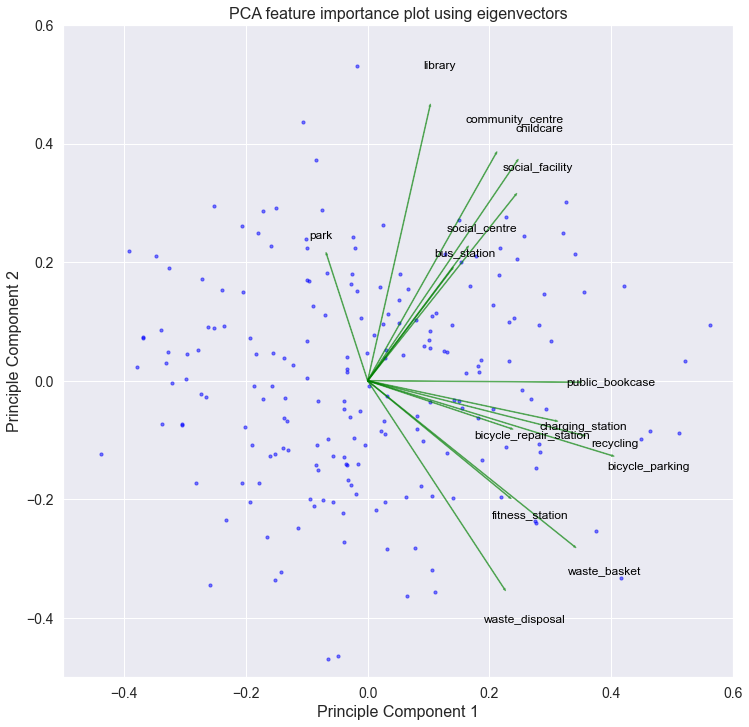

In [18]:
## Plot of feature importance to principle components
n_components=2 # ensuring n=2 for plot
pca_ = PCA(n_components=n_components) # 'pca_' object
X_pca = pca_.fit_transform(X_sc)

def pca_feat_plot(score, coeff, labels=None):
    """Plot feature importance to principle components"""
    
    xs = score[:,0]
    ys = score[:,1]
    
    n = coeff.shape[0]
    
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    plt.scatter(xs * scalex,ys * scaley, c = "blue", alpha=0.5, s=10)
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'green', alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center', fontsize=12)

plt.figure(figsize=(12,12))      
plt.title('PCA feature importance plot using eigenvectors', fontsize=16)
plt.xlim(-0.5,0.6)
plt.ylim(-0.5,0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Principle Component {}".format(1), fontsize=16)
plt.ylabel("Principle Component {}".format(2), fontsize=16)
plt.grid(b=True)

#Call the function. Use only the 2 PCs.
amenities_clean = [i[:-6] for i in amenities]
pca_feat_plot(X_pca[:,0:n_components], np.transpose(pca_.components_[0:n_components, :]), labels=amenities_clean)
plt.savefig('PCA_feat_importance_scatter.png', dpi=400, bbox_inches='tight')
plt.show()

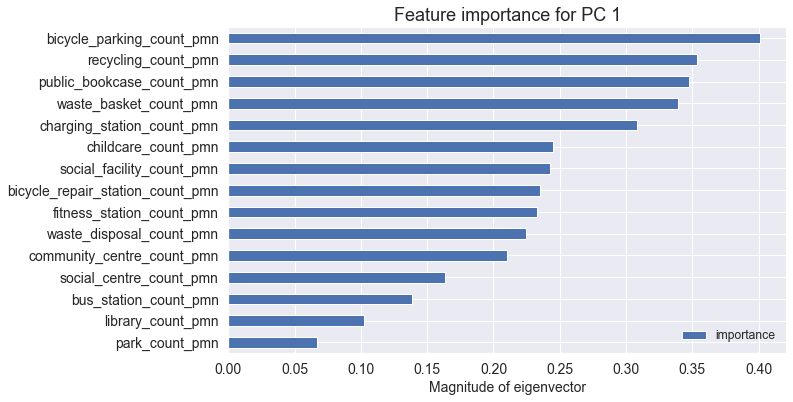

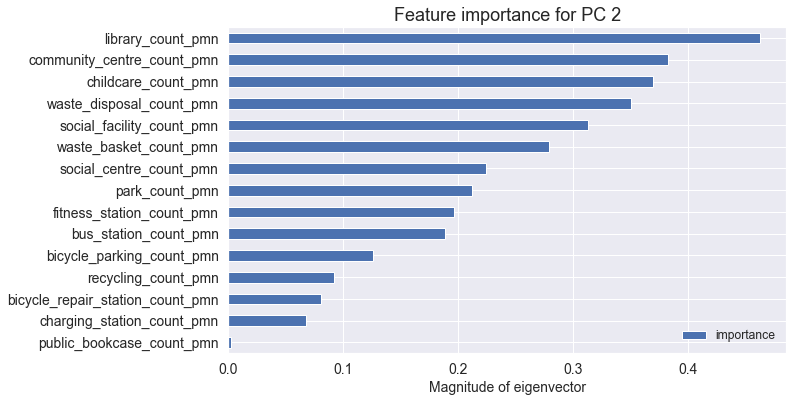

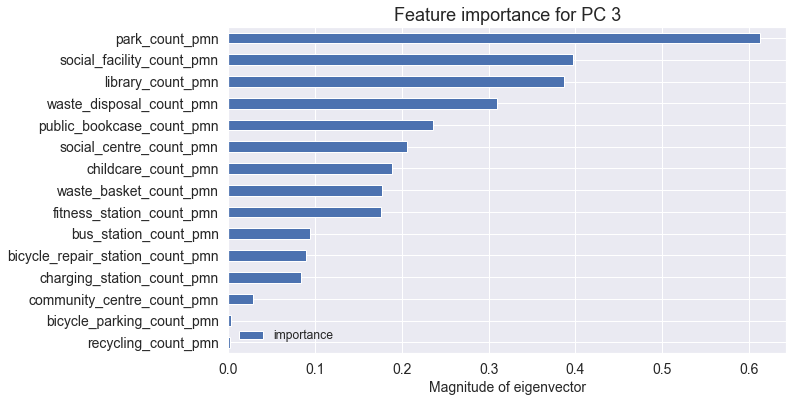

In [19]:
def plot_pc_vals(n, pca_, absolute=False):
    """Plot pca_ feat importance"""
    pc_feature_importance = {}
    
    if absolute == True:
        for i in range(len(amenities_pmn)):
            pc_feature_importance[amenities_pmn[i]] = abs(pca_.components_[n][i])
    else:
        for i in range(len(amenities_pmn)):
            pc_feature_importance[amenities_pmn[i]] = pca_.components_[n][i]
        
    pd.DataFrame.from_dict(pc_feature_importance, orient='index', columns=['importance']).sort_values('importance').plot(kind='barh', figsize=(10,6), fontsize=14)
    plt.title('Feature importance for PC '+str(n+1), fontsize=18)
    plt.xlabel('Magnitude of eigenvector', fontsize=14)
    plt.show()
    return

n_components=3 # plotting first largest 3x
pca_ = PCA(n_components=n_components) # 'pca_' object
X_pca = pca_.fit_transform(X_sc)

for i in range(n_components):
    plot_pc_vals(i, pca_, absolute=True)

**Interpretation of Principle Components**

    - PC1 = Green transport and clean environment

4 out of 5 of the underlying OSM features with the largest magnitude eigenvalues of the eigenvector are strictly environmental in nature.

    - PC2 = Social cohesion and education
    
Library, community centre, childcare, social facility. This PC is characterised by the prominence of amenity types which ensure social mobility and strive to reduce inequality.

    - PC3 = Health & wellbeing

This PC is largely defined by the 'parks' feature. Howevever, this feature has limitations in terms of interpration, given that it is based on nodes. This PC is less clear in terms of thematic categorisation, but given higher placement of fitness_station it is being considered in relation to health and wellbeing.

_On how many PCs to retain;_

**Selection of Principle Components**

The choice was made to retain the first two Principle Components, that combined explain about 40% of the variance. The plot of variance explained versus principle components shows a steeply falling curve which represents diminishing returns with little value added from subsequent PCs. The first two Principle Components display a logic thematic grouping of amenity types from the underlying OSM features. Furthermore, it has been noted that the OSM features tend to be quite noisy. Hence the decision was made to retain only the first two Principle Components which are framed broadly as:

- PC1: Environmental amenities
- PC2: Social amenities

## 4. Clustering and optimisation

### Partitional Clustering: KMeans
preprocess, dimensionality reduction, clustering

The 'kneed' package was introduced as an option to add objectivity to selected n_clusters for K-means using the elbow method. The package determines the point of maximum curvature on a convex curve

In [20]:


def kmeans_optimise(X):
    """Choose optimal number of clusters for x"""
    sse = []
    for i in range(1, 14):
        kmeans = KMeans(n_clusters = i, random_state=42).fit(X)
        sse.append(kmeans.inertia_)
    
    kl = KneeLocator(range(1, 14), sse, curve='convex', direction='decreasing')
    return kl.elbow

### Detailed silhouette coefficient plots for various n_cluster values under KMeans

For n_clusters = 2 Average silhouette_score is: 0.3941316206514166
For n_clusters = 3 Average silhouette_score is: 0.3619457612285072
For n_clusters = 4 Average silhouette_score is: 0.3643051692613629
For n_clusters = 5 Average silhouette_score is: 0.3621779929687122
For n_clusters = 6 Average silhouette_score is: 0.3544873318194216
For n_clusters = 7 Average silhouette_score is: 0.3620013987849451


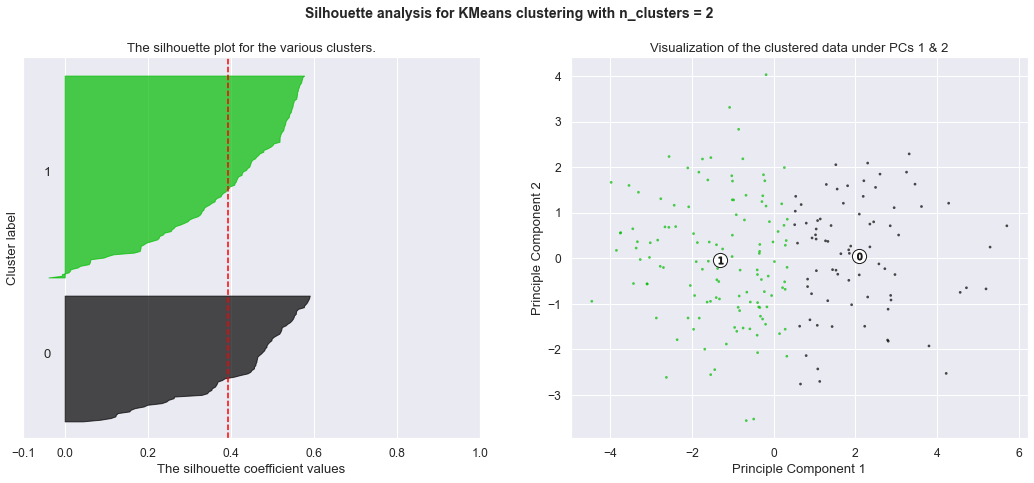

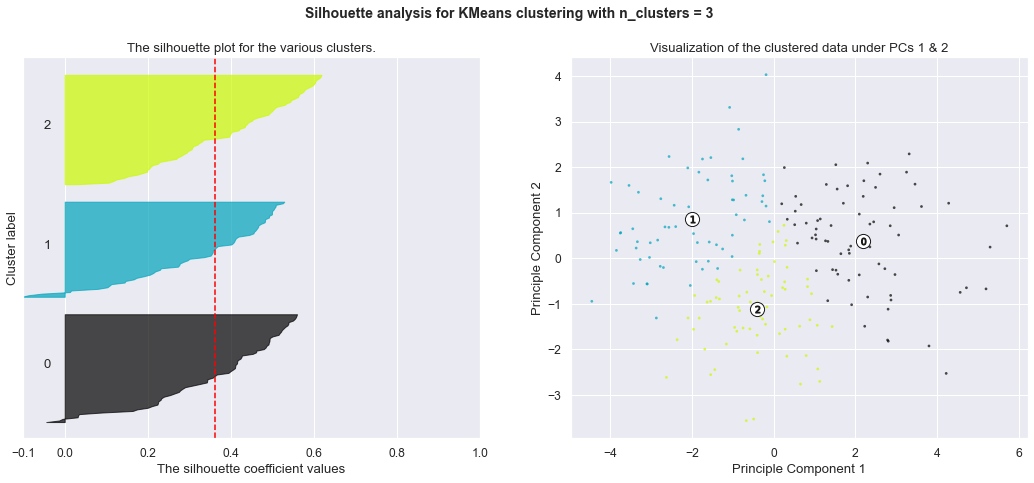

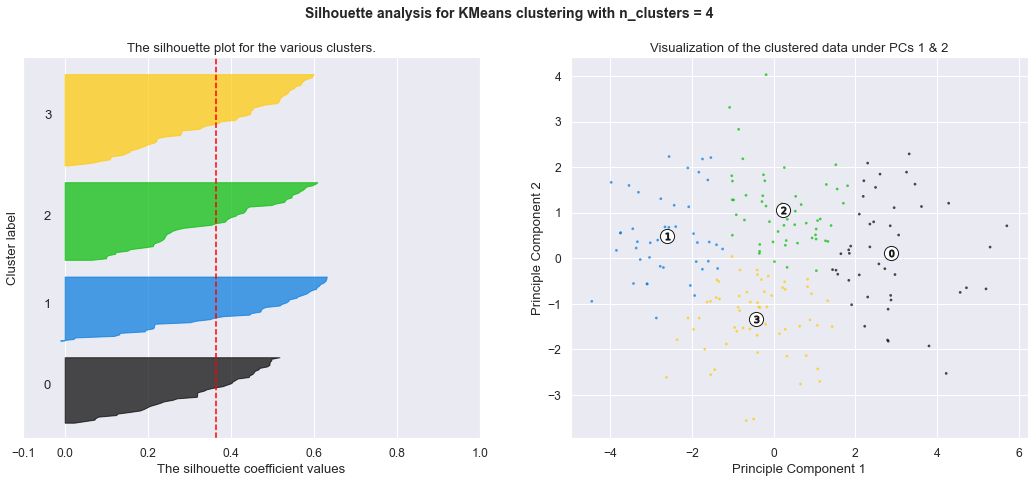

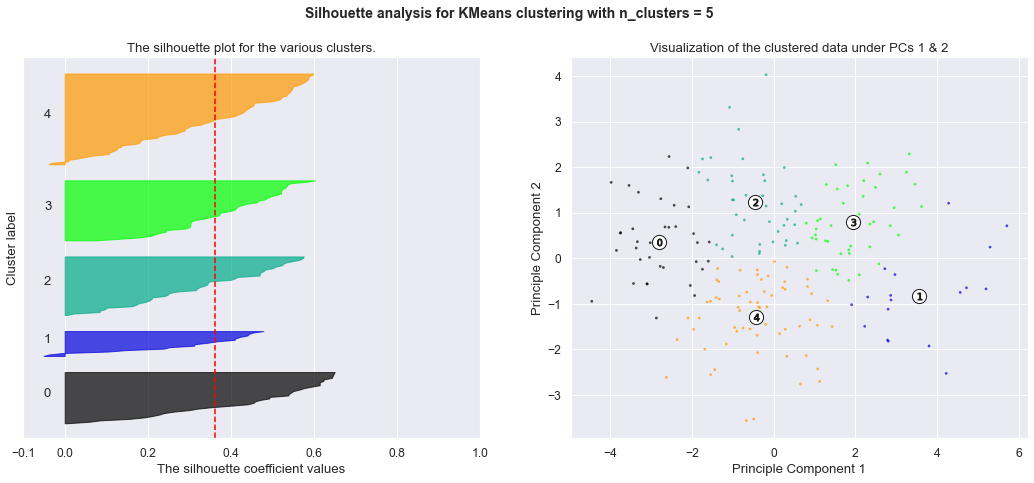

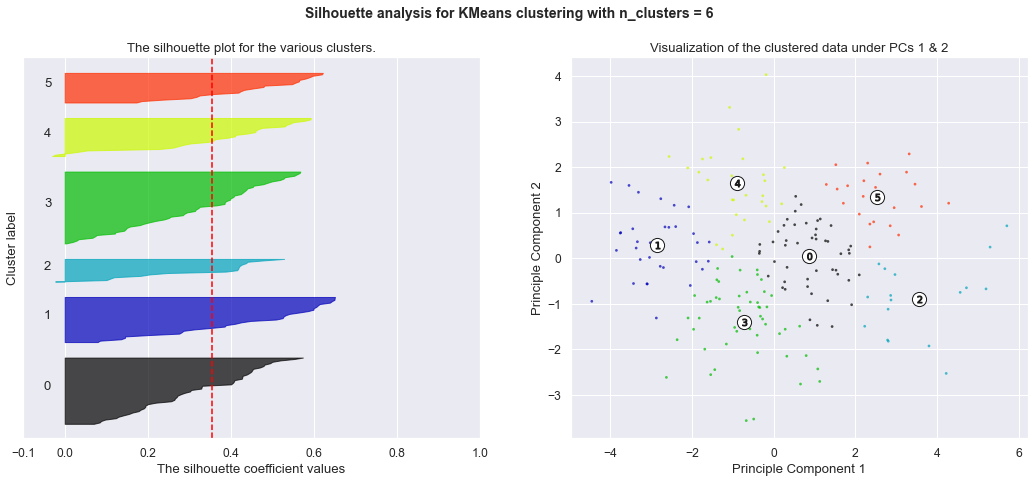

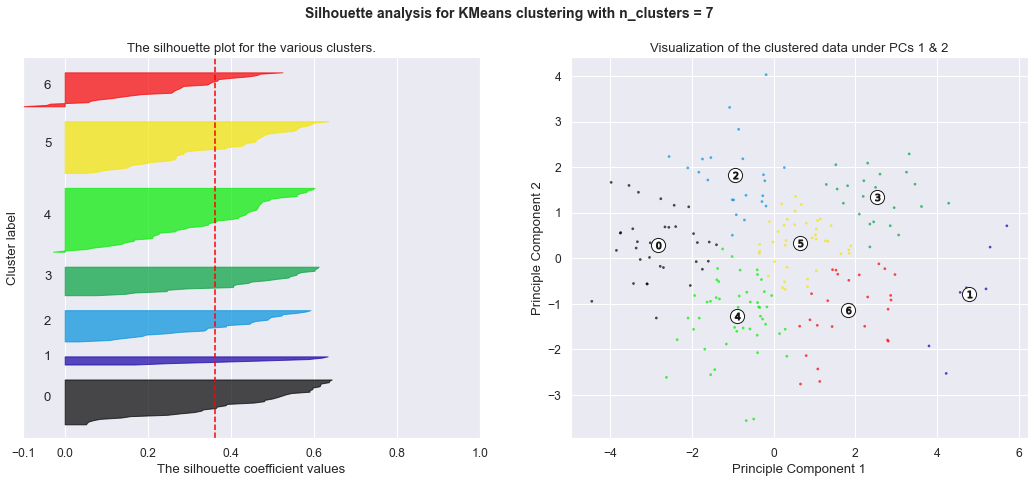

In [21]:
X_pca = pca(X_sc, retain_pcs='knee', print_log=False)

range_n_clusters = [2, 3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    #clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X_pca)

    # Average s for all samples cpatures the density and separation of clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =",
        n_clusters,
        "Average silhouette_score is:",
        silhouette_avg)

    # compute s for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # s for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of the clustered data under PCs 1 & 2")
    ax2.set_xlabel("Principle Component 1")
    ax2.set_ylabel("Principle Component 2")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Scaler:  StandardScaler()
Transform:  log
Shape of preprocessed dataset:  (200, 15)


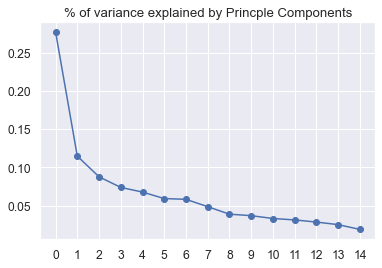

Principle Components retained:  2
Explained variance by 2 PCs:  0.3921795802088099


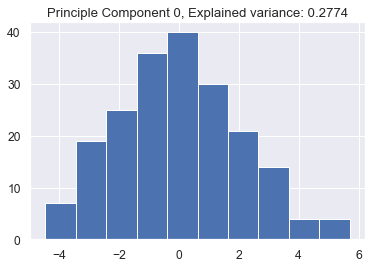

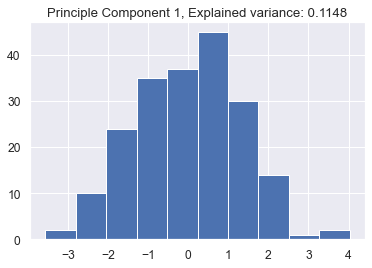

Cumulative variance:
PC 0: 0.2774
PC 1: 0.3922
Number of clusters: 4
Sum of squared errors:  335.11394
Cluster label relative frequency: 
2    62
0    51
3    48
1    39
Name: kmeans_n4, dtype: int64
[[ 2.66167032  0.15214447]
 [-2.70492292  0.39478674]
 [-0.46533697 -1.30166819]
 [-0.02921458  1.19890368]]


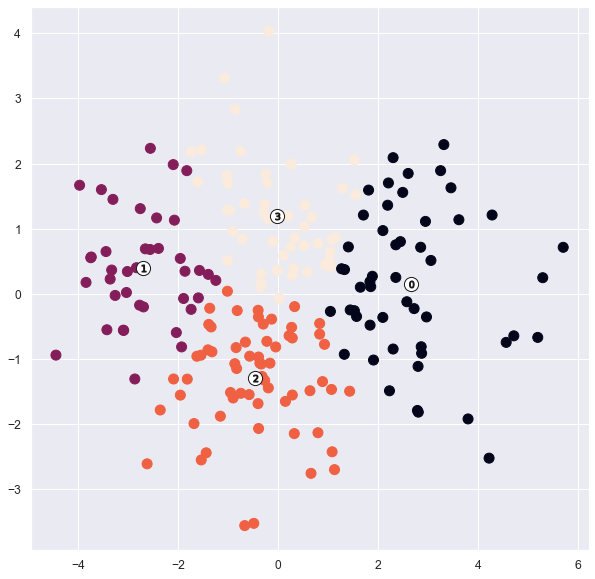

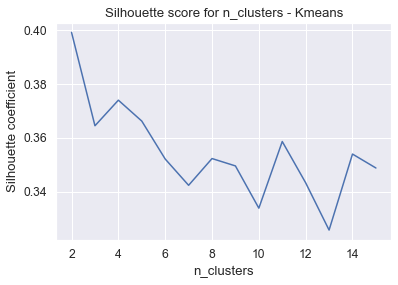

In [22]:
## Full pipeline: preprocess, dimensionality reduction, clustering
X_sc = preprocess(df[amenities_pmn], transform='log', scaler='sc', print_log=True)

X_pca = pca(X_sc, retain_pcs='knee', print_log=True) # 'knee' to retain using kneed
#X_pca = X_sc

n_clusters = kmeans_optimise(X_pca)

print("Number of clusters:", n_clusters)

kmeans = KMeans(n_clusters = n_clusters, random_state=42).fit(X_pca)
labels = kmeans.labels_
header = 'kmeans_n'+str(n_clusters)
df[header] = labels

print("Sum of squared errors: ", round(kmeans.inertia_, 5))
print("Cluster label relative frequency: ")

print(df[header].value_counts())

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=100)
centers = kmeans.cluster_centers_
print(centers)
ax.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

for i, c in enumerate(centers):
    ax.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

plt.show()

# n = [i for i in df['city']]
# for i, txt in enumerate(n):
#     ax.annotate(txt, (X_pca[:,0][i],X_pca[:,1][i]), fontsize=12)

## Silhouette coefficient
coefs = []

for i in range(2,16):
    kmeans = KMeans(n_clusters = i, random_state=42)
    kmeans.fit(X_pca)
    coef = silhouette_score(X_pca_df, kmeans.labels_)
    coefs.append(round(coef,5))

plt.title('Silhouette score for n_clusters - Kmeans')
plt.plot(range(2,16), coefs)
plt.ylabel('Silhouette coefficient')
plt.xlabel('n_clusters')
plt.show()

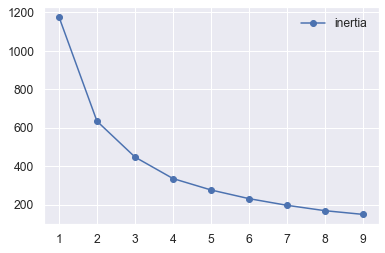

In [23]:
## Optimising kmeans algorithm: Elbow method 

results = {}
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, random_state=42).fit(X_pca)
    results[i] = kmeans.inertia_

pd.DataFrame().from_dict(results, orient='index', columns=['inertia']).sort_values('inertia').plot(marker='o')

### Pipeline: Agglomerative Hierarchical
preprocess, dimensionality reduction, clustering

[[ 2.7293446   0.25888162]
 [-0.60269786 -1.04771452]
 [-2.91153685  0.73746455]
 [ 0.10080214  1.15177675]]
Cluster label relative frequency: 
1    79
0    49
3    41
2    31
Name: agg_n4, dtype: int64


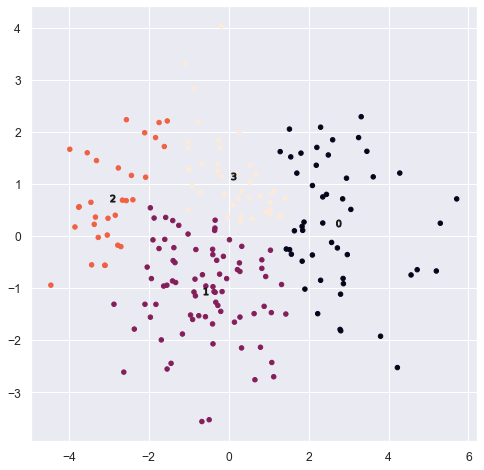

[0.3862, 0.3158, 0.3395, 0.3354, 0.3229, 0.3337, 0.3123, 0.3114, 0.3274, 0.3417, 0.3271, 0.3346, 0.3433, 0.3454]


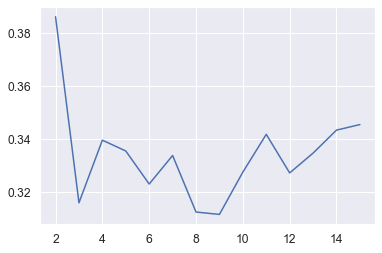

In [24]:


## Full pipeline: preprocess, dimensionality reduction, clustering
X_sc = preprocess(df[amenities_pmn], transform='log', scaler='sc')
X_pca = pca(X_sc, retain_pcs='knee') # 'knee' to retain using kneed

n_clusters = 4

agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(X_pca)

# Agglomerative Clustering centroid
y_predict = agg.fit_predict(X_pca)
clf = NearestCentroid()
centroids = clf.fit(X_pca, y_predict).centroids_
print(centroids)

labels = agg.labels_
header = 'agg_n'+str(n_clusters)
df[header] = labels

print("Cluster label relative frequency: ")
print(df[header].value_counts())

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=20)
# ax.scatter(X_pca[mask_index][:,0], X_pca[mask_index][:,1], c='red', s=40)
for i, c in enumerate(centroids):
    ax.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
plt.show()

# n = [i for i in df['city']]
# for i, txt in enumerate(n):
#     ax.annotate(txt, (X_pca[:,0][i],X_pca[:,1][i]), fontsize=12)

## Silhouette

coefs = []

for i in range(2,16):
    agg = AgglomerativeClustering(n_clusters=i)
    agg.fit(X_pca)
    coef = silhouette_score(X_pca, agg.labels_)
    coefs.append(round(coef,4))

print(coefs)
plt.plot(range(2,16), coefs)

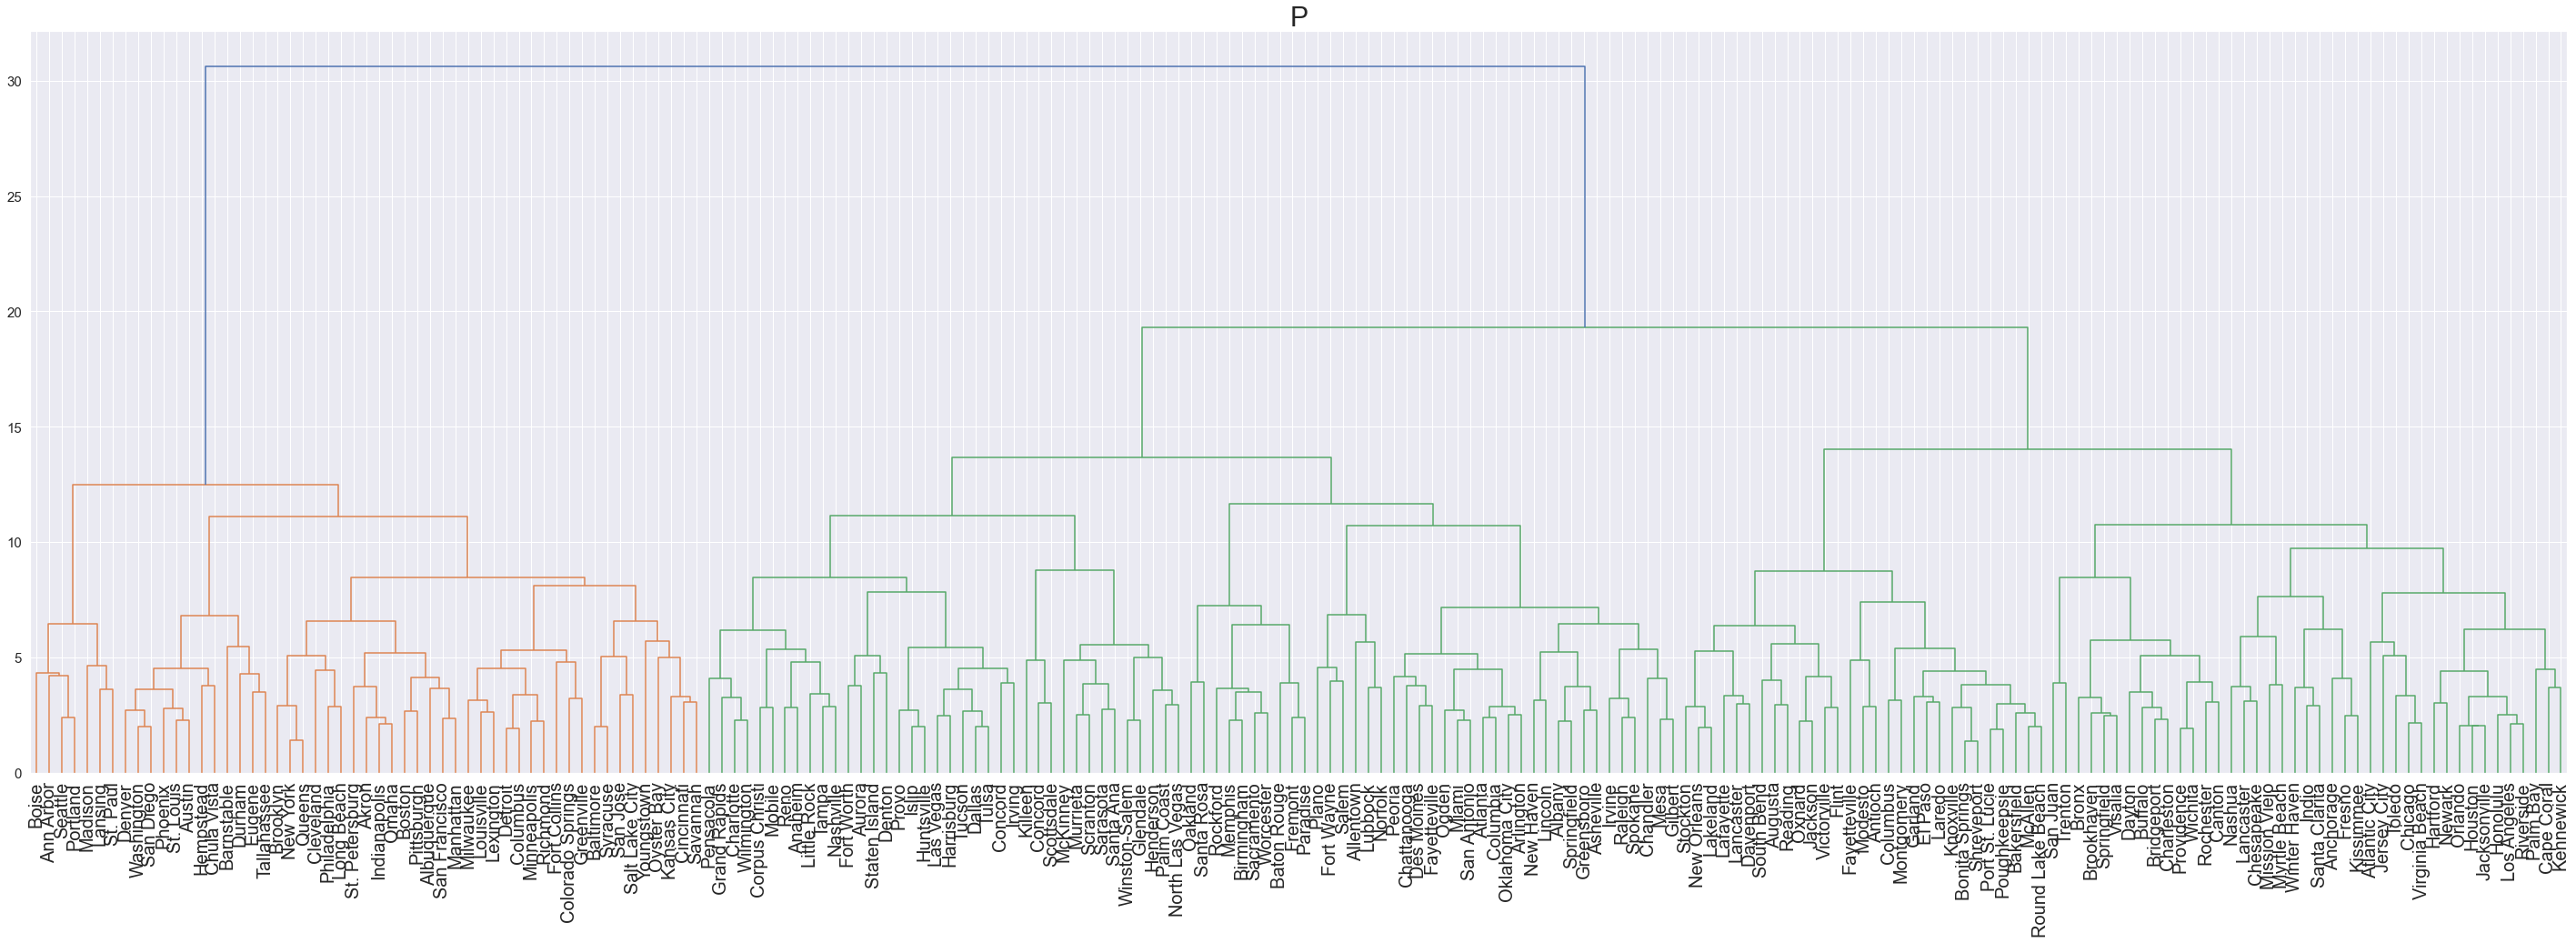

In [25]:


## Agglomerative Hierarchical clustering: Dendrogram

plt.figure(figsize=(50, 15))
plt.yticks(fontsize=15)
plt.title("P", fontsize = 30)  
dend = shc.dendrogram(shc.linkage(X_sc, method='ward'), labels=list(df['city']), leaf_font_size=20)

### Pipeline: Density-based


Density-based algorithms were considered but were found to be problematic in dealing the noisiness of the data, the presence of outliers and the lack of uniform density.

[[ -1 136]
 [  0  11]
 [  1  15]
 [  2   8]
 [  3  10]
 [  4  20]]


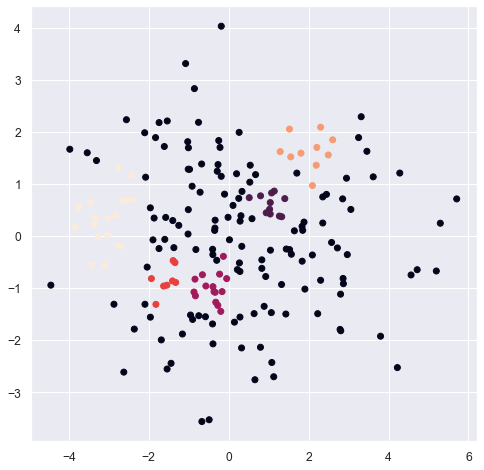

In [26]:


## Full pipeline: preprocess, dimensionality reduction, clustering
X_sc = preprocess(df[amenities_pmn], transform='log', scaler='sc')
X_pca_df = pca(X_sc, retain_pcs='knee') # 'knee' to retain using kneed

ops = OPTICS(max_eps=20, min_samples=6).fit(X_pca)

np.unique(ops.labels_)

unique, counts = np.unique(ops.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

plt.figure(figsize=(8,8))
plt.scatter(X_pca[:,0], X_pca[:,1], c=ops.labels_)

### Comparing cluster labels from KMeans & Hierarchical algorithms

27 cities are assigned to different clusters between the use of KMeans & Hierarchical clustering algorithms, which represents 13% of samples.

In [27]:
## Manually aligning agglomerative cluster labels with those of KMeans
mapper = {'kmeans_n4':{0:'A',
             3:'B',
             2:'C',
             1:'D'},
'agg_n4':{0:'A',
             3:'B',
             1:'C',
             2:'D'}}
df['kmeans_n4_'] = df['kmeans_n4'].map(mapper['kmeans_n4'])
df['agg_n4_'] = df['agg_n4'].map(mapper['agg_n4'])

misaligned = list(df[df['kmeans_n4_'] != df['agg_n4_']].sort_values('kmeans_n4_')['city'])
print(str(len(misaligned))+' samples which are not assigned to the same cluster between KMeans and Agglomerative Hierarchical:')
misaligned

26 samples which are not assigned to the same cluster between KMeans and Agglomerative Hierarchical:


['Fremont',
 'San Francisco',
 'Detroit',
 'Youngstown',
 'Salem',
 'Reading',
 'Canton',
 'Fayetteville',
 'Columbia',
 'Chicago',
 'Indianapolis',
 'Pittsburgh',
 'Houston',
 'Philadelphia',
 'Little Rock',
 'Baton Rouge',
 'Fresno',
 'New Orleans',
 'Lancaster',
 'Scranton',
 'Lancaster',
 'Mobile',
 'Santa Clarita',
 'Davenport',
 'Newark',
 'Knoxville']

## 5. Definition of final model clusters


- K-means was preferred over Agglomerative Hierarchical due to a higher mean silhouette coefficient value, lower prevalence of negative silhouette coefficient values among the samples (indicating incorrect assignment) and slightly more even cluster sizes


- n_clusters was set at four based on evidence from both the silhouette and elbow methods of optimisation

### Replotting K-means with samples highlight where there is disagreement with Agglomerative Hierarchical

Number of clusters: 4
[[ 2.66167032  0.15214447]
 [-2.70492292  0.39478674]
 [-0.46533697 -1.30166819]
 [-0.02921458  1.19890368]]


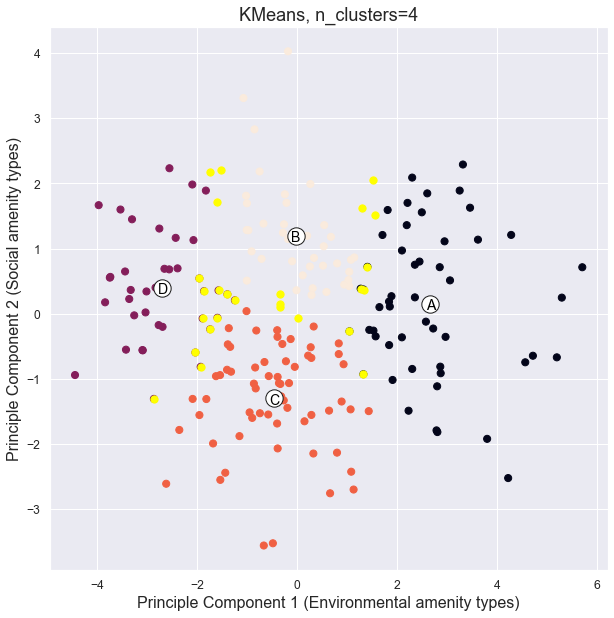

In [28]:
## REPLOTTING KMEANS WITH MISMATCHED SAMPLES IN YELLOW
mask = np.array(df['kmeans_n4_'] != df['agg_n4_'])

## Full pipeline: preprocess, dimensionality reduction, clustering
X_sc = preprocess(df[amenities_pmn], transform='log', scaler='sc', print_log=False)
X_pca = pca(X_sc, retain_pcs='knee', print_log=False) # 'knee' to retain using kneed
n_clusters = kmeans_optimise(X_pca)
print("Number of clusters:", n_clusters)
kmeans = KMeans(n_clusters = n_clusters, random_state=42).fit(X_pca)
labels = kmeans.labels_

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=50)
ax.scatter(X_pca[:,0][mask], X_pca[:,1][mask], c='yellow', s=52)

centers = kmeans.cluster_centers_

print(centers)
ax.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=300,
        edgecolor="k",
    )

letters = []
for i in range(4):
    letters.append(mapper['kmeans_n4'][i])
letters

n = [i for i in letters]
for i, txt in enumerate(n):
    ax.annotate(txt, (centers[i]-0.09), fontsize=14, color='black')
    
plt.xlabel('Principle Component 1 (Environmental amenity types)', fontsize=16)
plt.ylabel('Principle Component 2 (Social amenity types)', fontsize=16)
plt.title('KMeans, n_clusters=4', fontsize=18)

# for i, c in enumerate(centers):
#     letter = mapper['kmeans_n4'][i]
#     ax.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

# n = [i for i in df['city'][mask]]
# for i, txt in enumerate(n):
#     ax.annotate(txt, (X_pca[:,0][mask][i],X_pca[:,1][mask][i]), fontsize=12)

plt.show()

### Characterisation of clusters under KMeans


The below chart illustrates the normalised Principle Component 1 & 2 values for the K-means cluster centroids for each of the clusters A-D.

Given the interpretation of PCs 1 & 2, this chart captures the typical profile of each cluster under the environmental and social dimensions.

Text(0.5, 1.0, 'Cluster characteristics: Principle component values for Kmeans centroids')

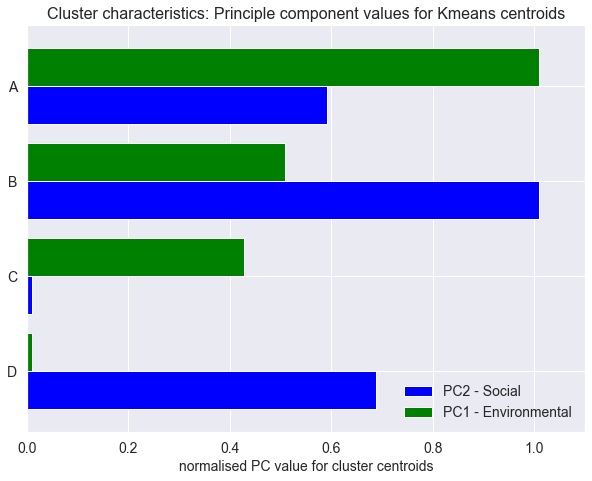

In [29]:
temp = pd.DataFrame(centers).rename(columns={0:'PC1 - Environmental', 1:'PC2 - Social'})
temp_n = (temp-temp.min())/(temp.max()-temp.min()) # normalising PC values
temp_n = temp_n.sort_values('PC1 - Environmental')
temp_n.index = temp_n.index.map(mapper['kmeans_n4'])
temp_n = temp_n +0.01
temp_n = temp_n[temp_n.columns[::-1]] # reversing columns

temp_n.plot(kind='barh',
            color={'PC1 - Environmental':'green',
                   'PC2 - Social':'blue'},
            figsize=(10,7.5),
            fontsize=14,
           width=0.8)
plt.xlabel('normalised PC value for cluster centroids', fontsize=14)
plt.xlim(0, 1.1)
plt.legend(fontsize=14)
plt.title('Cluster characteristics: Principle component values for Kmeans centroids', fontsize=16)

## 6. Exploratory analysis of cluster characteristics using OSM features

- Cluster sample frequency
- Mean OSM feature value per cluster

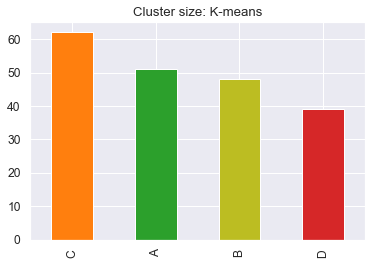

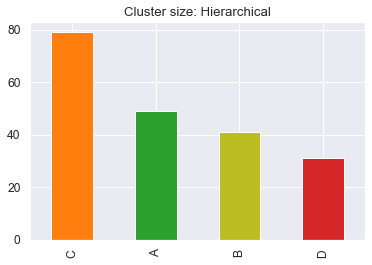

In [30]:
cat_colors = {'A':plt.get_cmap("tab10")(0.2),
 'B':plt.get_cmap("tab10")(0.8),
 'C':plt.get_cmap("tab10")(0.1),
 'D':plt.get_cmap("tab10")(0.3)}

## Relative frequency of samples in identified clusters
df['kmeans_n4_'].value_counts().plot(kind='bar',
                                     color=df['kmeans_n4_'].value_counts().index.map(cat_colors))
plt.title('Cluster size: K-means')
df['kmeans_n4_'].value_counts()
plt.show()

## Relative frequency of samples in identified clusters
df['agg_n4_'].value_counts().plot(kind='bar',
                                     color=df['agg_n4_'].value_counts().index.map(cat_colors))
plt.title('Cluster size: Hierarchical')
df['agg_n4_'].value_counts()
plt.show()

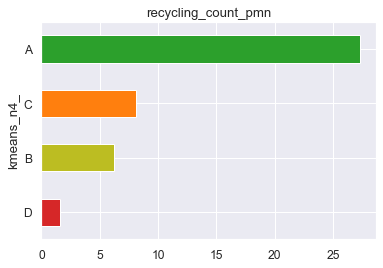

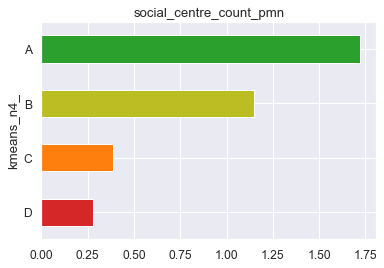

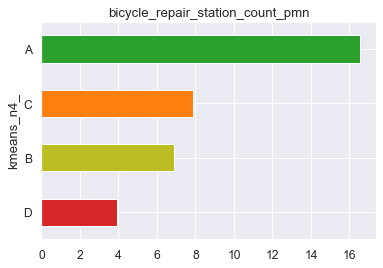

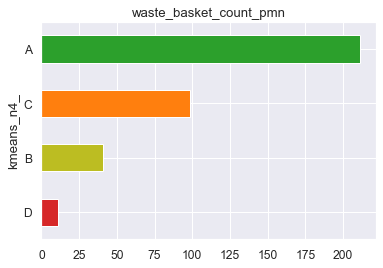

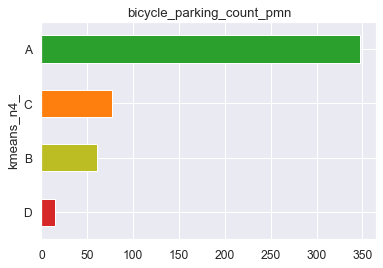

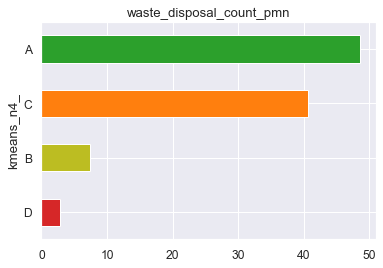

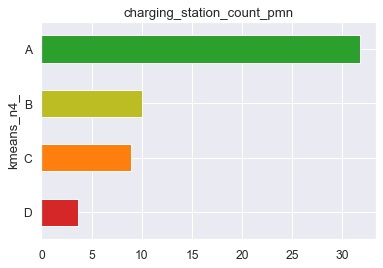

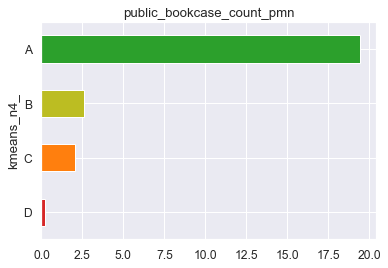

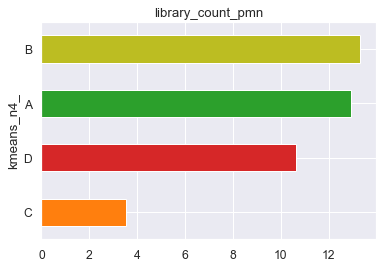

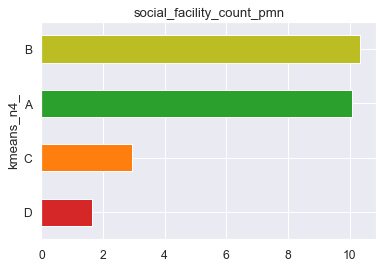

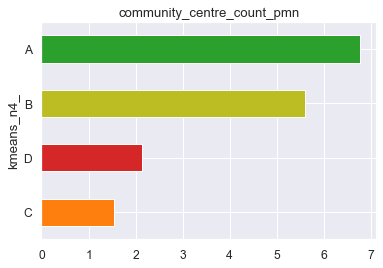

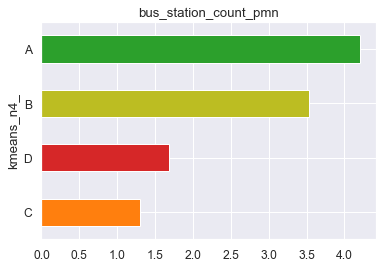

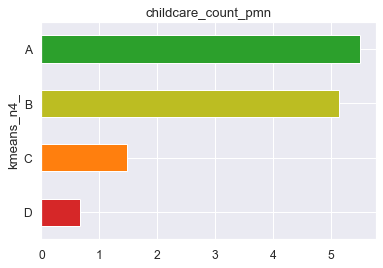

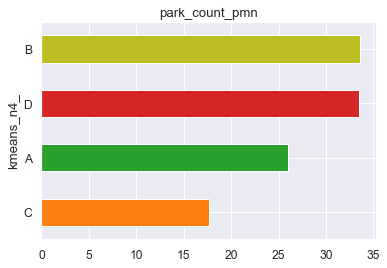

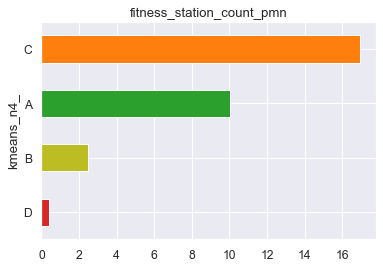

In [31]:
## Mean value of OSM feature counts per cluster
gb = df.groupby('kmeans_n4_').mean()[amenities_pmn]
for i in amenities_pmn:
    plt.title(str(i))
    temp = gb[i].sort_values()
    temp.plot(kind='barh',
              color=temp.index.map(cat_colors))
    plt.show()

Text(0, 0.5, 'Mean value for amenity count in each cluster')

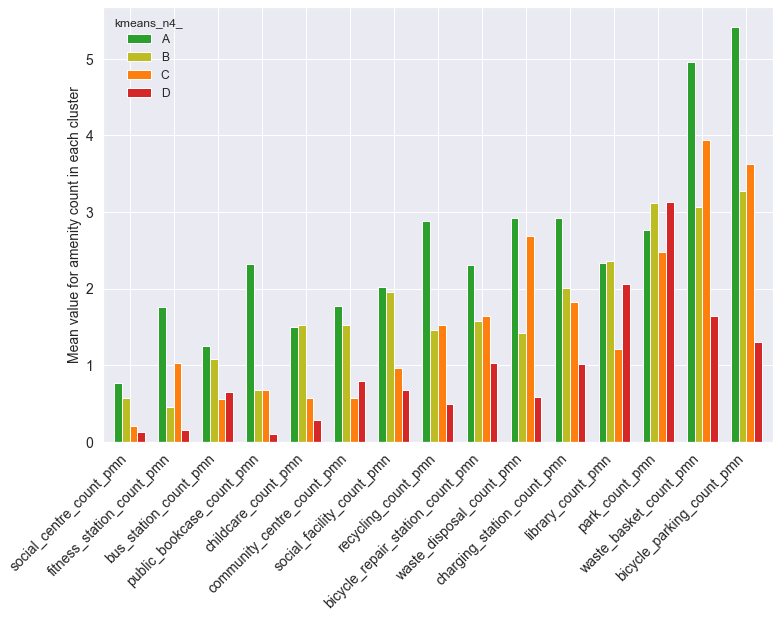

In [32]:
## Mean amenity_pmn per cluster
gb_df = (np.log(1+df[amenities_pmn])).join(df['kmeans_n4_'])
gb_T = gb_df.groupby('kmeans_n4_').mean()[amenities_pmn].T
gb_T['sum'] = gb_T.sum(axis=1)
gb_T = gb_T.sort_values('sum')

gb_T
gb_T.iloc[:,:-1].plot(kind='bar',
                      color=cat_colors,
                      figsize=(12,8),
                      fontsize=14,
                      width=0.7)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean value for amenity count in each cluster', fontsize=14)

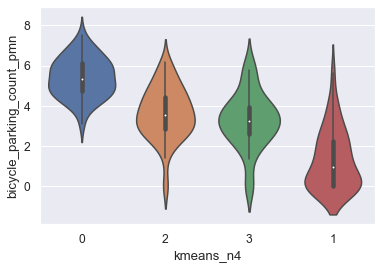

In [33]:
## Violinplot of log-transformed OSM feature distribution per cluster
temp = pd.concat([np.log(df['bicycle_parking_count_pmn']+1), df['kmeans_n4']], axis=1)
# temp = pd.concat([round((10*df['bicycle_parking_count_pmn'].rank()/df['bicycle_parking_count_pmn'].shape[0]), 0), df['labels']], axis=1)
plot_order = temp.groupby('kmeans_n4')['bicycle_parking_count_pmn'].mean().sort_values(ascending=False).index
sns.violinplot(x='kmeans_n4', y='bicycle_parking_count_pmn', data=temp, order=plot_order)

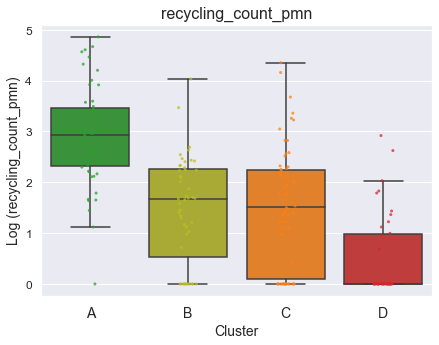

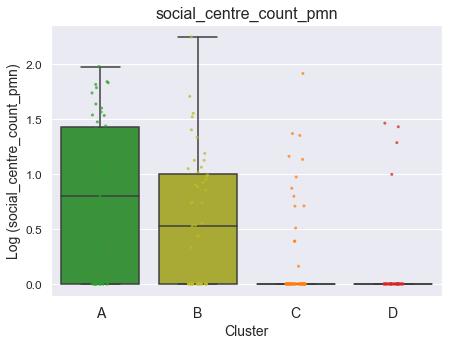

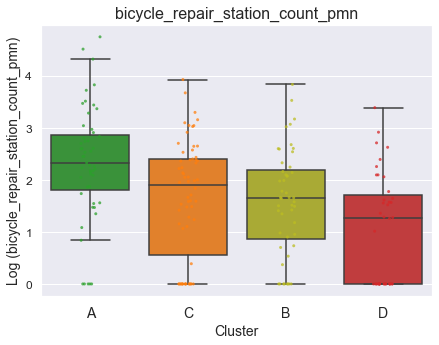

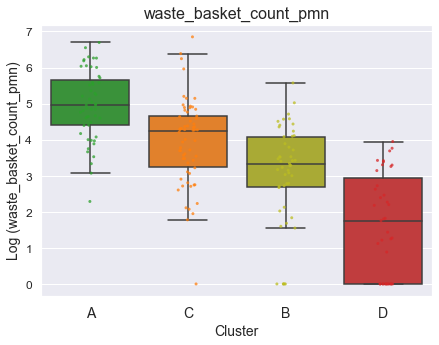

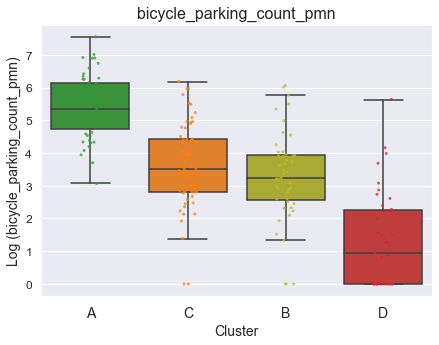

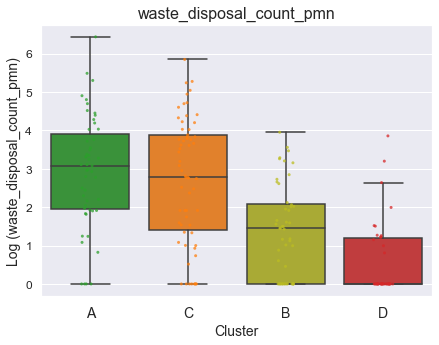

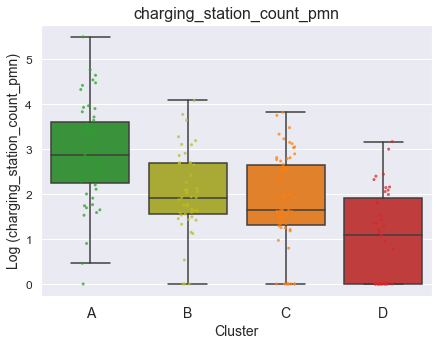

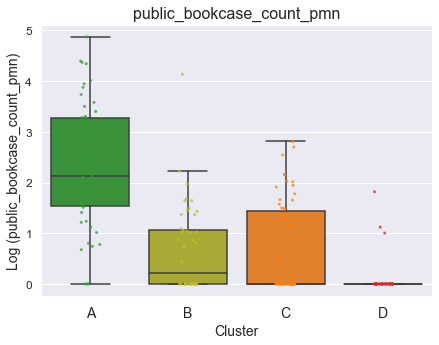

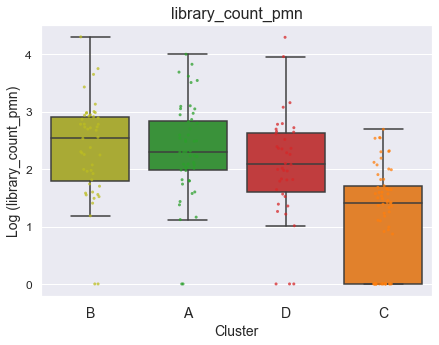

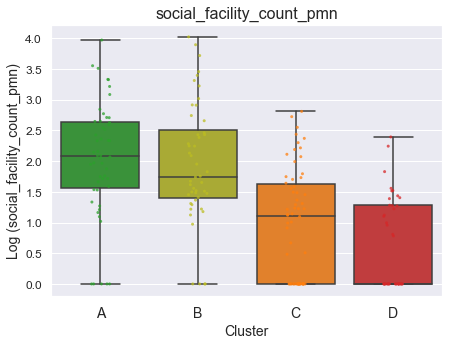

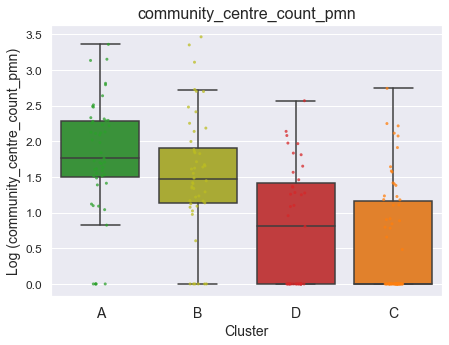

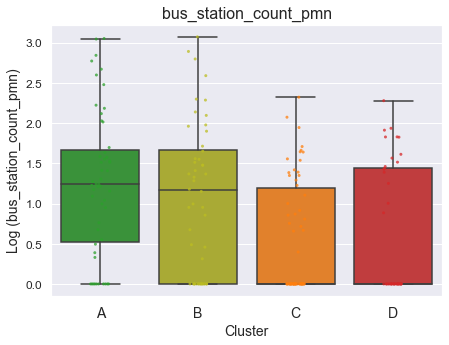

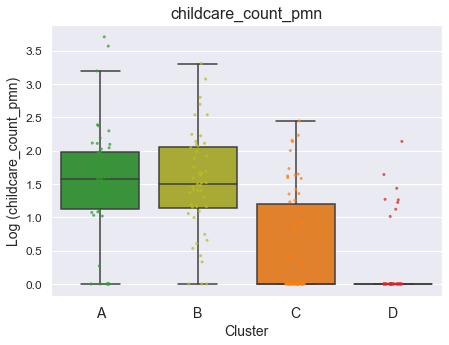

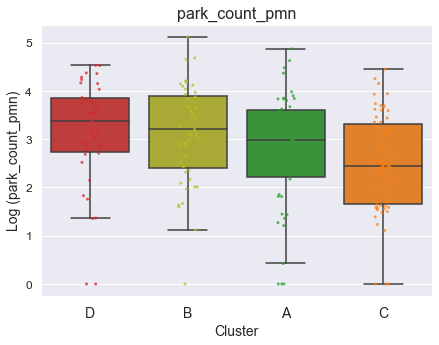

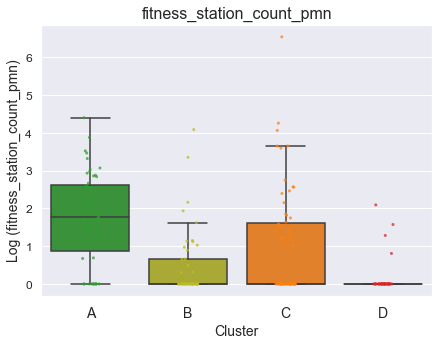

In [34]:
## Violinplot of all log-transformed OSM features per cluster

cat_colors = {'A':plt.get_cmap("tab10")(0.2),
 'B':plt.get_cmap("tab10")(0.8),
 'C':plt.get_cmap("tab10")(0.1),
 'D':plt.get_cmap("tab10")(0.3)}

for i in amenities_pmn:
    temp = pd.concat([np.log(df[i]+1), df['kmeans_n4_']], axis=1)
    plot_order = temp.groupby('kmeans_n4_')[i].median().sort_values(ascending=False).index
    #sns.violinplot(x='kmeans_n4_', y=i, data=temp, order=plot_order, palette=cat_colors)
    plt.figure(figsize=(7,5))
    sns.boxplot(x='kmeans_n4_', y=i, data=temp, order=plot_order, fliersize=0, palette=cat_colors)
    sns.stripplot(x='kmeans_n4_', y=i, data=temp, order=plot_order, alpha=.75, s=3, palette=cat_colors)
    plt.ylabel('Log ('+str(i)+')', fontsize=14)
    plt.title(i, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
    plt.xlabel('Cluster', fontsize=14)
    plt.show()

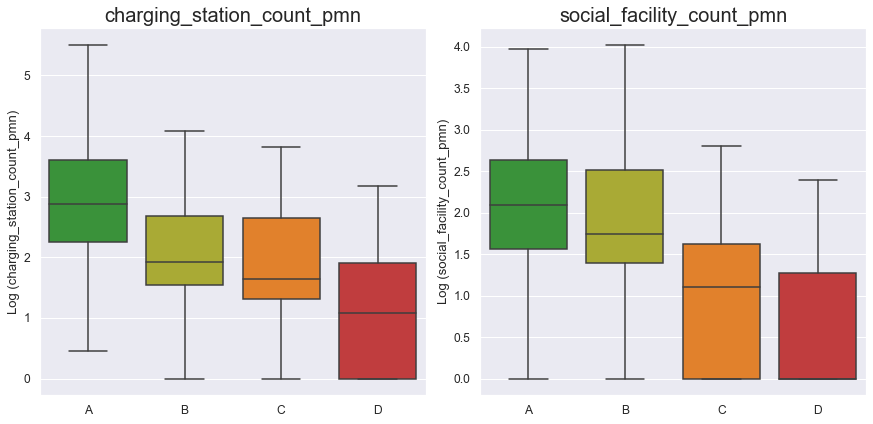

In [35]:
## Generating Education subplots
fig, axes = plt.subplots(1, 2, figsize=(12.5, 6))
sns.set(font_scale=1.5)
plt.tight_layout()
plt.grid(b=True)
plt.style.use('seaborn-whitegrid')

y = 'charging_station_count_pmn'
temp = pd.concat([np.log(df[y]+1), df['kmeans_n4_']], axis=1)
order = [i for i in temp.groupby('kmeans_n4_').mean()[y].sort_values(ascending=False).index]
sns.boxplot(x='kmeans_n4_',
                y=y,
                data=temp,
                order=order,
                fliersize=0,
                palette=cat_colors,
           ax=axes[0])
axes[0].set_title(y, fontsize=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('Log ('+str(y)+')')

y = 'social_facility_count_pmn'
temp = pd.concat([np.log(df[y]+1), df['kmeans_n4_']], axis=1)
order = [i for i in temp.groupby('kmeans_n4_').mean()[y].sort_values(ascending=False).index]
sns.boxplot(x='kmeans_n4_',
                y=y,
                data=temp,
                order=order,
                fliersize=0,
                palette=cat_colors,
           ax=axes[1])
axes[1].set_title(y, fontsize=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Log ('+str(y)+')')
plt.savefig('OSM_subplots_env_soc.png', dpi=400, bbox_inches='tight')

### Preliminary interpretation of cluster characteristics

Cluster A

Highest prevalence of amenities across 14 of 16 features. This cluster is characterised by anomalously high access to sustainable lifestyles for citizens, particularly on the environmental dimension

Cluster B

The overall leader on social / on par with A, yet moderate on environmental

Cluster C

Moderate on environmental, much poorer on social.

Cluster D

Overall Laggard. However, some moderate outcomes on the social dimension runner-up for features relating to social cohesion and equality (childcare, community centre, library, social facility, social centre). This group can be characterising as lagging but making efforts to ensure access for lower sociodemographic communities

## 7. Exploratory analysis of cluster characteristics using socioeconomic, demographic and cultural (SEDC) features

In [36]:
city_df = pd.read_csv(r"PATH\uscities.csv")
city_df = pd.concat([city_df,
                     df[['kmeans_n4','kmeans_n4_',
                         'agg_n4', 'agg_n4_']],
                         df[amenities],
                         df[amenities_pmn]], axis=1)
city_df = city_df.head(200)

## SEDC features subset
SEDC_features = ['age_20s',
'age_median',
'family_size',
'education_less_highschool',
'education_college_or_above',
'income_individual_median',
'family_dual_income',
'income_household_six_figure',
'rent_burden',
'home_value',
 'unemployment_rate',
'labor_force_participation',
'hispanic',
'limited_english']

<ipython-input-36-4e9904c8169d>:1: DtypeWarning: Columns (2,20) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.read_csv(r"PATH\uscities.csv")


In [37]:
city_df

city     city_ascii city_alt state_id     state_name  \
0         New York       New York      NaN       NY       New York   
1      Los Angeles    Los Angeles      NaN       CA     California   
2          Chicago        Chicago      NaN       IL       Illinois   
3            Miami          Miami      NaN       FL        Florida   
4           Dallas         Dallas      NaN       TX          Texas   
..             ...            ...      ...      ...            ...   
195         Irving         Irving      NaN       TX          Texas   
196        Visalia        Visalia      NaN       CA     California   
197  Atlantic City  Atlantic City      NaN       NJ     New Jersey   
198       Paradise       Paradise      NaN       NV         Nevada   
199         Nashua         Nashua      NaN       NH  New Hampshire   

     county_fips   county_name                county_fips_all  \
0          36061      New York                          36061   
1           6037   Los Angeles                          06037   
2          17031          Cook                          17031   
3          12086    Miami-Dade                          12086   
4          48113        Dallas  48113|48085|48121|48257|48397   
..           ...           ...                            ...   
195        48113        Dallas                          48113   
196         6107        Tulare                          06107   
197        34001      Atlantic                          34001   
198        32003         Clark                          32003   
199        33011  Hillsborough                          33011   

                           county_name_all      lat  ...  \
0                                 New York  40.6943  ...   
1                              Los Angeles  34.1139  ...   
2                                     Cook  41.8373  ...   
3                               Miami-Dade  25.7839  ...   
4    Dallas|Collin|Denton|Kaufman|Rockwall  32.7936  ...   
..                                     ...      ...  ...   
195                                 Dallas  32.8584  ...   
196                                 Tulare  36.3276  ...   
197                               Atlantic  39.3797  ...   
198                                  Clark  36.0807  ...   
199                           Hillsborough  42.7491  ...   

     waste_disposal_count_pmn  charging_station_count_pmn  \
0                    3.259728                    3.633795   
1                    3.999747                    5.960407   
2                    0.581111                    4.881335   
3                    1.086021                    2.482335   
4                   23.328943                    4.178318   
..                        ...                         ...   
195                 20.850883                    0.000000   
196                  0.000000                    0.000000   
197                  0.000000                    4.218448   
198                 51.044932                   25.522466   
199                  0.000000                    0.000000   

     public_bookcase_count_pmn  library_count_pmn social_facility_count_pmn  \
0                     4.168176           4.702558                  6.038512   
1                     1.725381          11.607108                 10.352286   
2                     3.254224           3.951557                  3.370446   
3                     0.000000           9.153609                  0.620584   
4                     2.089159           1.566869                  1.740966   
..                         ...                ...                       ...   
195                   0.000000           4.170177                  0.000000   
196                   0.000000          12.637645                  8.425097   
197                   0.000000           8.436896                  4.218448   
198                   0.000000          17.014977                  0.000000   
199                   4.275021           0.000000                  0.

### Median SEDC values by cluster

Th table below shows the median value for a subset of SEDC features spanning age, income, education, employment

In [38]:
city_df.groupby('kmeans_n4_').median()[['age_median',
                               'income_household_median',
                               'income_individual_median',
                               'home_ownership',
                               'rent_median',
                               'rent_burden',
                               'education_less_highschool',
                               'education_college_or_above',
                               'unemployment_rate',
                               'race_white',
                               'race_black',
                               'race_native',
                               'hispanic',
                               'poverty',
                               'limited_english',
                               'health_uninsured']].sort_values('income_individual_median', ascending=False)

age_median  income_household_median  income_individual_median  \
kmeans_n4_                                                                  
A                34.70                  60035.0                   31508.0   
C                35.00                  56333.0                   29716.0   
B                34.35                  48092.5                   26694.0   
D                34.40                  47593.0                   25819.0   

            home_ownership  rent_median  rent_burden  \
kmeans_n4_                                             
A                    49.90       1058.0         32.2   
C                    55.20       1055.0         32.0   
B                    46.25        981.5         34.0   
D                    54.10       1005.0         35.7   

            education_less_highschool  education_college_or_above  \
kmeans_n4_                                                          
A                                10.6                        41.5   
C                                11.6                        33.1   
B                                13.9                        29.7   
D                                15.7                        22.8   

            unemployment_rate  race_white  race_black  race_native  hispanic  \
kmeans_n4_                                                                     
A                         5.4        63.6        18.9          0.5      10.9   
C                         5.4        66.4        11.5          0.5      17.1   
B                         6.8        55.0        26.6          0.4      17.1   
D                         6.4        64.0        16.8          0.4      33.2   

            poverty  limited_english  health_uninsured  
kmeans_n4_                                              
A              16.3              3.6               7.4  
C              15.7              4.2              11.2  
B              20.1              3.9               9.8  
D              20.0              5.7               9.2

### Distribution of values in each cluster for a selection of SEDC features

Color coding for clusters A-D matches preceding analysis with OSM features

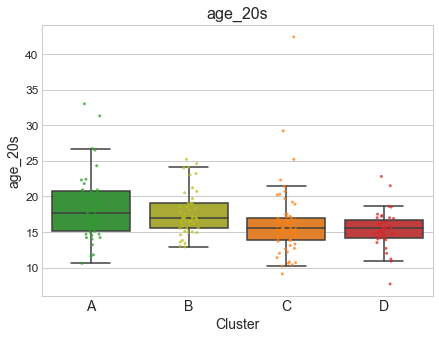

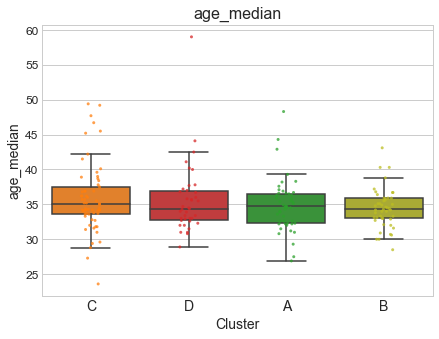

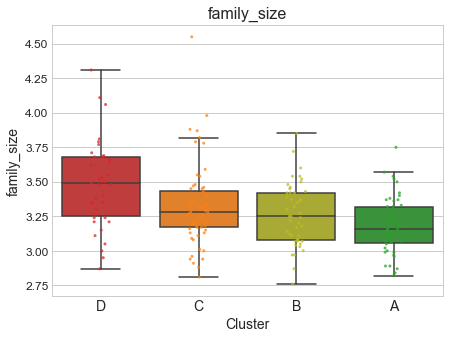

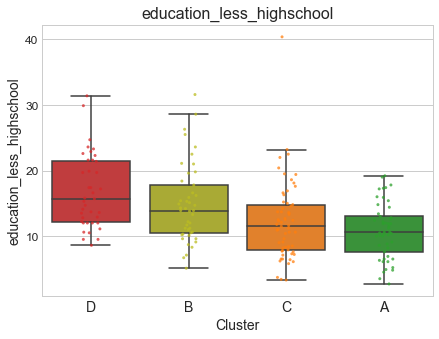

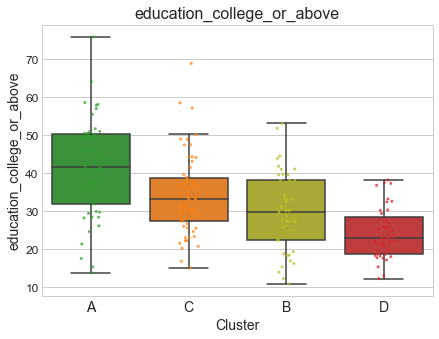

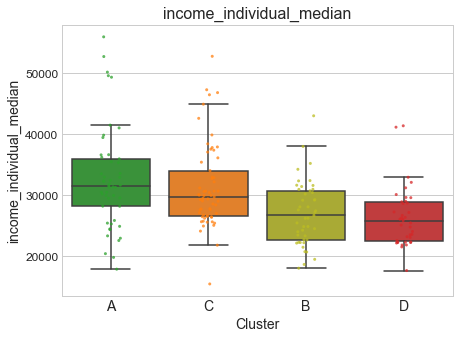

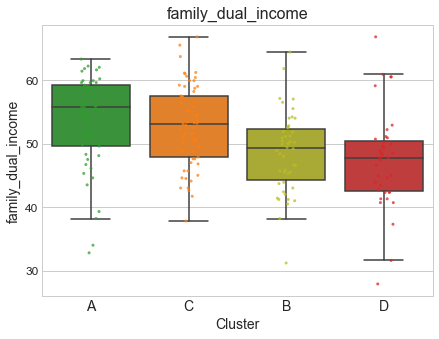

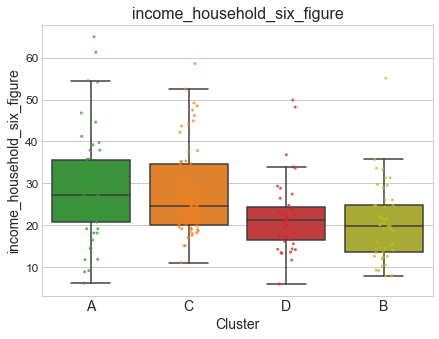

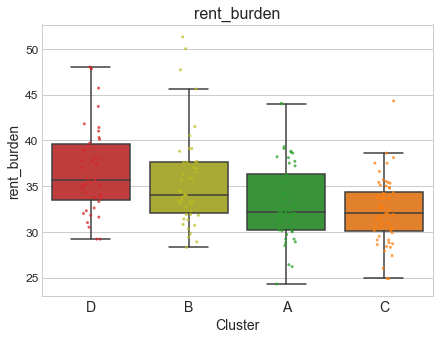

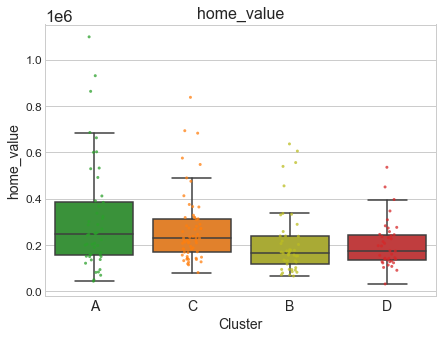

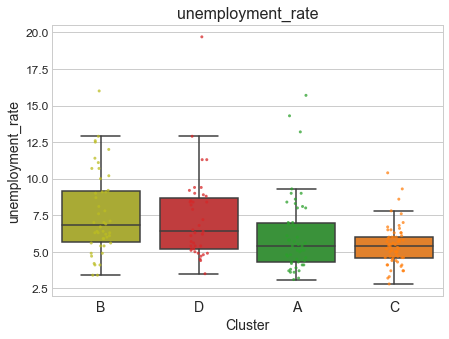

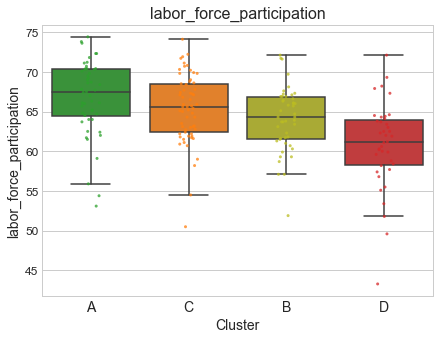

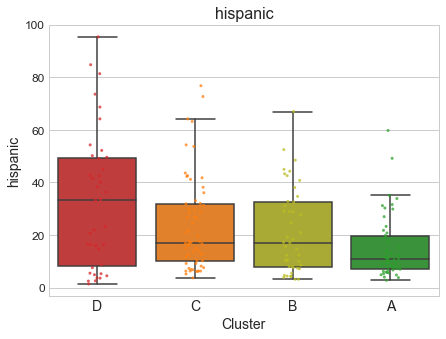

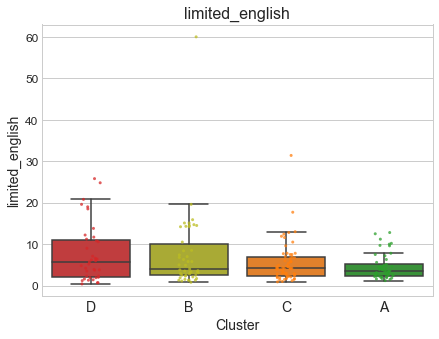

In [39]:

## Boxplot of all log-transformed OSM features per cluster

for i in SEDC_features:
    order = [i for i in city_df.groupby('kmeans_n4_').mean()[i].sort_values(ascending=False).index]
    plt.figure(figsize=(7,5))
    sns.boxplot(x='kmeans_n4_',
                y=i,
                data=city_df,
                order=order,
                fliersize=0,
                palette=cat_colors)
    sns.stripplot(x='kmeans_n4_', y=i, data=city_df, order=order, alpha=.75, s=3, palette=cat_colors)
    plt.ylabel(str(i), fontsize=14)
    plt.title(i, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
    plt.xlabel('Cluster', fontsize=14)
    plt.show()

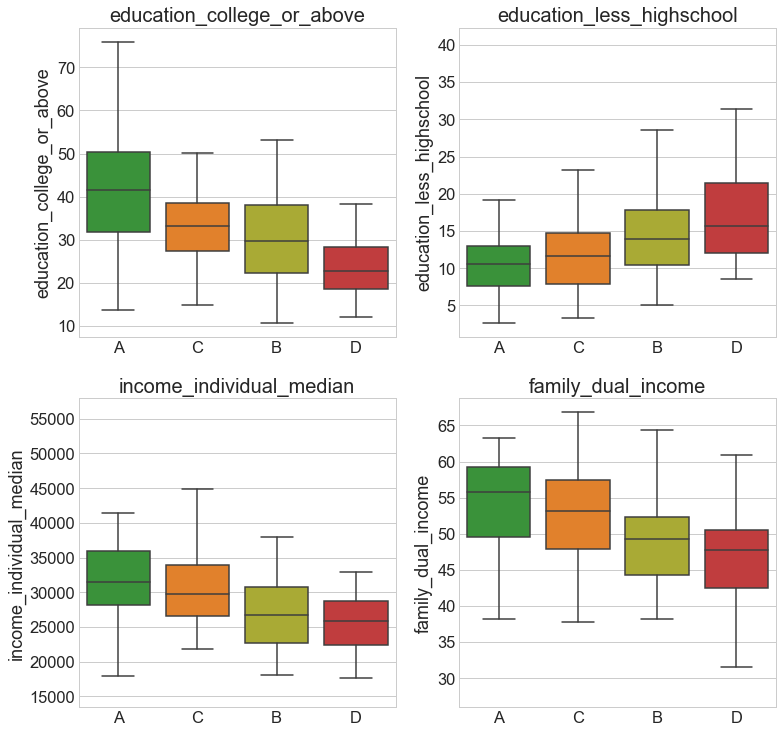

In [40]:
## Generating Education & income subplots
fig, axes = plt.subplots(2, 2, figsize=(12.5, 12.5))
sns.set(font_scale=1.5)
#plt.tight_layout()
plt.grid(b=True)
plt.style.use('seaborn-whitegrid')

y = 'education_college_or_above'
order = [i for i in city_df.groupby('kmeans_n4_').mean()[y].sort_values(ascending=False).index]
sns.boxplot(x='kmeans_n4_',
                y=y,
                data=city_df,
                order=order,
                fliersize=0,
                palette=cat_colors,
           ax=axes[0,0])
axes[0,0].set_title(y, fontsize=20)
axes[0,0].set_xlabel('')

y = 'income_individual_median'
order = [i for i in city_df.groupby('kmeans_n4_').mean()[y].sort_values(ascending=False).index]
sns.boxplot(x='kmeans_n4_',
                y=y,
                data=city_df,
                order=order,
                fliersize=0,
                palette=cat_colors,
           ax=axes[1,0])
axes[1,0].set_title(y, fontsize=20)
axes[1,0].set_xlabel('')

y = 'education_less_highschool'
order = [i for i in city_df.groupby('kmeans_n4_').mean()[y].sort_values(ascending=True).index]
sns.boxplot(x='kmeans_n4_',
                y=y,
                data=city_df,
                order=order,
                fliersize=0,
                palette=cat_colors,
           ax=axes[0,1])
axes[0,1].set_title(y, fontsize=20)
axes[0,1].set_xlabel('')

y = 'family_dual_income'
order = [i for i in city_df.groupby('kmeans_n4_').mean()[y].sort_values(ascending=False).index]
sns.boxplot(x='kmeans_n4_',
                y=y,
                data=city_df,
                order=order,
                fliersize=0,
                palette=cat_colors,
           ax=axes[1,1])
axes[1,1].set_title(y, fontsize=20)
axes[1,1].set_xlabel('')
plt.savefig('SEDC_subplots_edu_income.png', dpi=400, bbox_inches='tight')

### Reflections on SEDC characteristics of clusters



- **Age**

All clusters display similar distributions

- **Income**

Noteworthy that A is high. Suggests Environmental outcomes with wealth. Seattle, Denver, Portland

C is also high, a cohort of cities that are prosperous, middle ground on environmental yet very poor on social. These locations might have high income on average but are potentially at risk of an under supply of amenities and facilities to enable social equality. Examples include Dallas, Miami, Tuscon, Phoenix

B is joint least prosperous and is highest on Social amenities, perhaps suggesting a societal response to issues of poverty, inequality, etc. Examples include Chicago, LA, Bronx, Atlanta

D is joint least prosperous, yet completely lags on provision of sustainable amenities, both environmental and social. Examples include: New Orleans, El Paso, Fresno, Bakersfield

- **Race**

Trends not clear. However, Hispanic distribution clearly suggests higher proportion of hispanics lack access to sustainable amenities, are in overall laggard group across E&S.

- **Education**

Follows the cluster ordering of income. Most notable with tertiary education. Might be indicative that more well-educated populations have higher access to sustainable amenities.

In [41]:
#### Function to calculate mean and 95% confidence inverval for clusters under amenity


def calc_mean_ci(df, amenity):
    """Calculate mean and 95% confidence interval for given amenity for all clusters"""

    clusters = ['A', 'B', 'C', 'D']
    
    output = {}
    for c in clusters:
        group = df[df['kmeans_n4_']==c][amenity].dropna()
        mean = group.mean()
        interval = st.t.interval(alpha=0.95, df=len(group)-1, loc=np.mean(group), scale=st.sem(group))
        magnitude = interval[1] - mean
        output[c] = [mean, magnitude]
        
    return output
    
calc_mean_ci(city_df, 'income_individual_median')

{'A': [32597.897959183672, 2413.741442000468],
 'B': [27011.88888888889, 1572.3167733887967],
 'C': [31289.44262295082, 1749.8857637016954],
 'D': [26313.48717948718, 1582.2093880795364]}


### Investigating correlates between all individual OSM features and SEDC features of interest

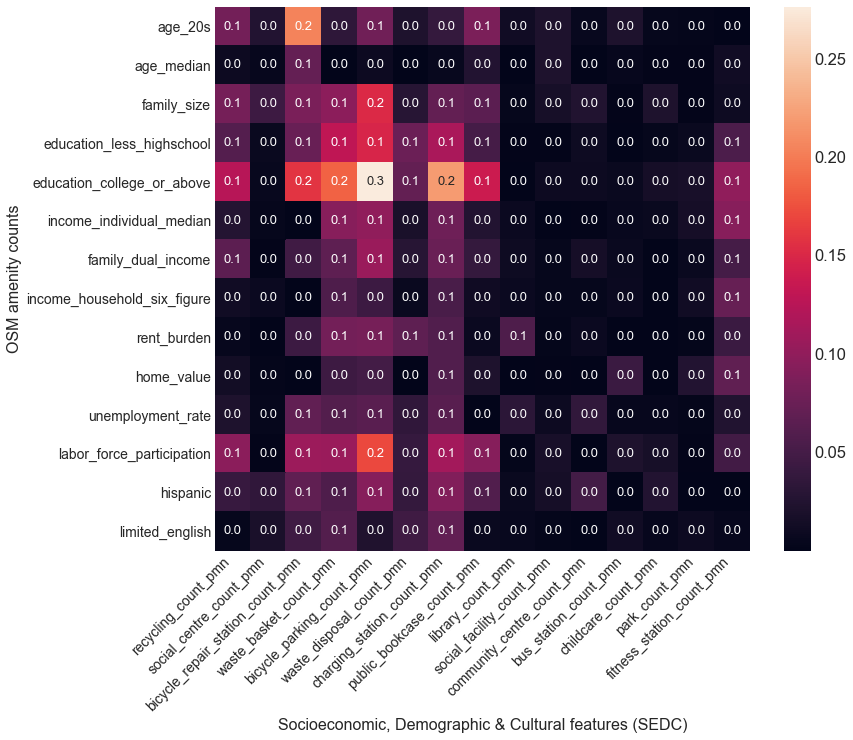

In [42]:
temp = city_df[SEDC_features].join(np.log(1+df[amenities_pmn])).corr()**2
temp = temp.replace(1, np.nan)

plt.figure(figsize=(12,10))
sns.heatmap(temp.iloc[:14,14:],
            annot=True,
            annot_kws={"fontsize":13},
            fmt=".1f")
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)
plt.xlabel('Socioeconomic, Demographic & Cultural features (SEDC)', fontsize=16)
plt.ylabel('OSM amenity counts', fontsize=16)
plt.savefig('correl_SEDC_OSM_subset.png', dpi=400, bbox_inches='tight')

### 8. Generalised Linear models using SEDC features for a representative OSM amenity type

The OSM feature **'bicycle_parking'** was selected as a representative OSM amenity type given:

- The strong data coverage across cities, relatively high counts, and the apparent higher statistical qualities of this amenity type revealed in the EDA phase of the analysis

- The strong thematic relevance of this amenity type as beneficial to the environment and human health

- The above preliminary correlation matrix which suggests a strong relationship with certain SEDC variables

Various linear models were developed using 'bicycle_parking' node counts as the target variable and SEDC features as the inputs

In [43]:

# Socioeconomic, Demographic and Cultural (SEDC) features used as independent variables
SEDC_features_all =  [
       'ranking', 'age_median', 'age_under_10',
       'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s',
       'age_70s', 'age_over_80', 
    #'male', 'female', 
    'married', 'divorced','never_married',
    'widowed','family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'income_household_150_over',
       'income_household_six_figure', 'income_individual_median',
       'home_ownership', 'home_value', 'rent_median', 'rent_burden',
       'education_less_highschool', 'education_highschool',
       'education_some_college', 'education_bachelors', 'education_graduate',
       'education_college_or_above', 'education_stem_degree',
       'labor_force_participation', 'unemployment_rate', 'race_white',
       'race_black', 'race_asian', 'race_native', 'race_pacific', 'race_other',
       'race_multiple', 'hispanic', 'disabled', 'poverty', 'limited_english',
       'commute_time', 'health_uninsured', 'veteran']

accuracy_scores = []

In [44]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

### Multiple Linear Regression using standard OLS

R-squared:  0.63749
ranking:  -0.06346
age_median:  0.79493
age_under_10:  -0.37992
age_10_to_19:  -0.57112
age_20s:  -1.19748
age_30s:  -0.66406
age_40s:  -0.39922
age_50s:  -0.35977
age_60s:  -0.48865
age_70s:  -1.14086
age_over_80:  -0.42712
married:  19.79242
divorced:  5.91871
never_married:  19.48599
widowed:  3.39815
family_size:  -0.04057
family_dual_income:  -0.07633
income_household_median:  1.41599
income_household_under_5:  1.08998
income_household_5_to_10:  1.77379
income_household_10_to_15:  1.10439
income_household_15_to_20:  0.58481
income_household_20_to_25:  0.42713
income_household_25_to_35:  1.63701
income_household_35_to_50:  1.65723
income_household_50_to_75:  1.27515
income_household_75_to_100:  1.3186
income_household_100_to_150:  -3.7673
income_household_150_over:  -7.91263
income_household_six_figure:  16.2892
income_individual_median:  -0.38852
home_ownership:  -0.28884
home_value:  0.53242
rent_median:  -0.58115
rent_burden:  -0.07896
education_less_highscho

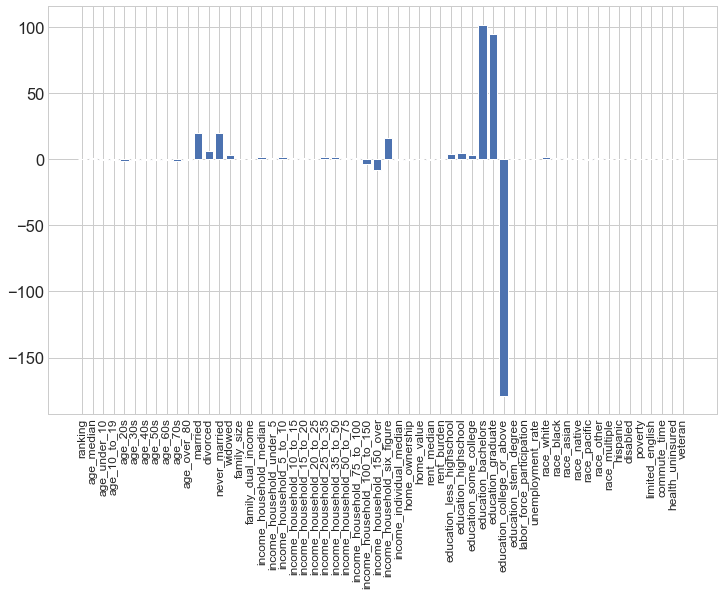

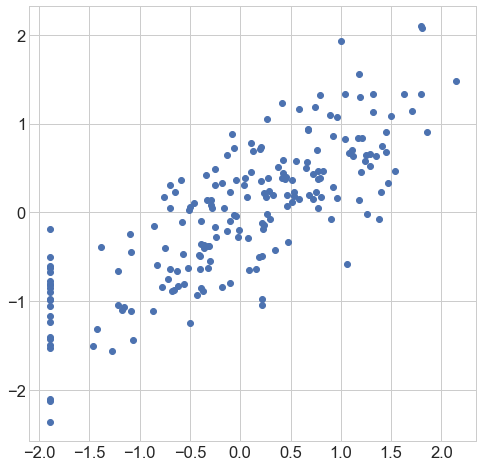

explained_variance:  0.6375
r2:  0.6375
MAE:  0.4809
MSE:  0.3625
RMSE:  0.6021
5x most influential SEDC features in terms of regression coefficient


SEDC feature  coefficient    coef_abs
40  education_college_or_above  -178.802826  178.802826
38         education_bachelors   101.537028  101.537028
39          education_graduate    94.886795   94.886795
11                     married    19.792419   19.792419
13               never_married    19.485989   19.485989

In [45]:
temp = pd.concat([city_df[SEDC_features_all], np.log(1+df['bicycle_parking_count_pmn'])], axis=1)
temp = temp.fillna(temp.median())
feats = [i for i in temp.iloc[:,:-1].columns]

scaler = StandardScaler()
t_scaled = scaler.fit_transform(temp.values)

X = t_scaled[:,:-1]
y = t_scaled[:,-1]

reg = LinearRegression().fit(X, y)
score = reg.score(X, y)
print("R-squared: ", round(score,5))

reg.coef_

importance = reg.coef_ # summarize feature importance
for i in range(len(feats)):
    print(feats[i]+':  '+str(round(importance[i],5)))

plt.figure(figsize=(12,7.5)) # plot feature importance
plt.bar([feats[i] for i in range(len(importance))], importance)
plt.xticks(rotation=90, fontsize=12)
plt.show()

y_pred = reg.predict(X) # plot observed vs. predicted
plt.figure(figsize=(8,8))
plt.scatter(y, y_pred)
plt.show()

regression_results(y, y_pred)
accuracy_scores.append(['LinearRegression', 'bicycle_parking_count_pmn_log', score])

print('5x most influential SEDC features in terms of regression coefficient')
importance_df = pd.DataFrame(list(zip(feats, list(importance))), columns=['SEDC feature', 'coefficient'])
importance_df['coef_abs'] = abs(importance_df['coefficient'])
importance_df.sort_values('coef_abs', ascending=False).head(5)

R-squared:  0.66326
ranking:  -0.14788
age_median:  1.09263
age_under_10:  0.08027
age_10_to_19:  -0.44006
age_20s:  -0.72445
age_30s:  -0.48109
age_40s:  -0.28897
age_50s:  -0.41912
age_60s:  -0.20069
age_70s:  -0.94427
age_over_80:  -0.34835
married:  18.74986
divorced:  5.83599
never_married:  18.93794
widowed:  3.18824
family_size:  -0.14983
family_dual_income:  -0.00982
income_household_median:  1.65865
income_household_under_5:  -0.28254
income_household_5_to_10:  -0.00622
income_household_10_to_15:  -0.5008
income_household_15_to_20:  -0.57289
income_household_20_to_25:  -0.87505
income_household_25_to_35:  -0.26634
income_household_35_to_50:  -0.17096
income_household_50_to_75:  -0.67602
income_household_75_to_100:  -0.45599
income_household_100_to_150:  16.20054
income_household_150_over:  30.02074
income_household_six_figure:  -47.507
income_individual_median:  -0.68781
home_ownership:  -0.07918
home_value:  0.32124
rent_median:  -0.40124
rent_burden:  -0.01814
education_less

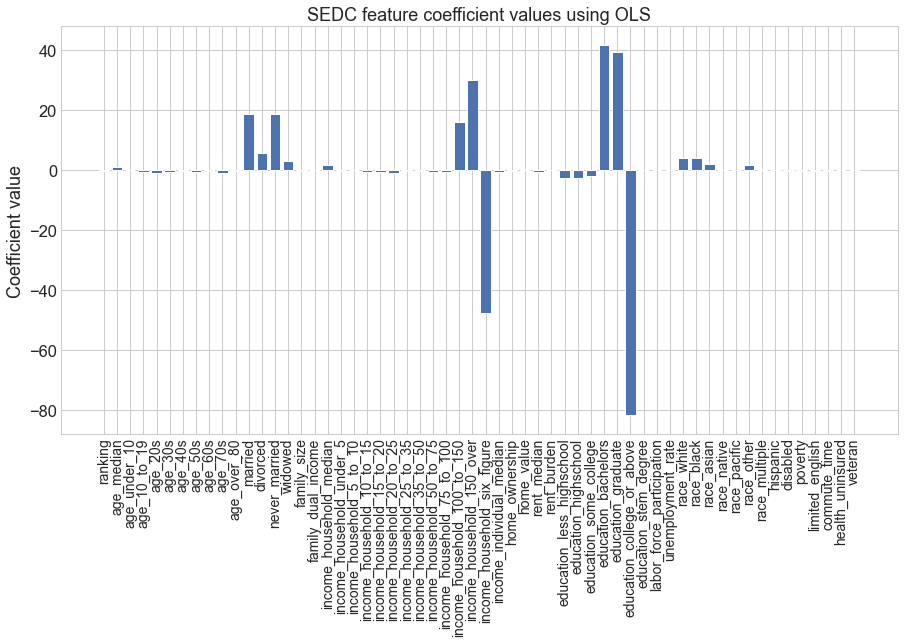

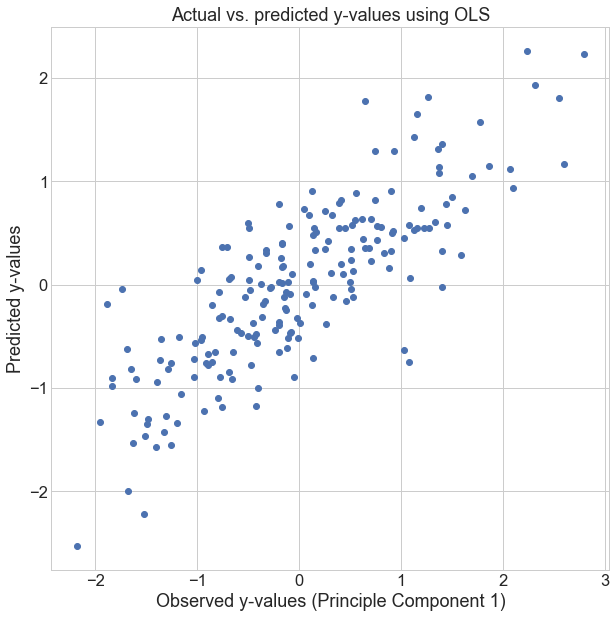

explained_variance:  0.6633
r2:  0.6633
MAE:  0.4573
MSE:  0.3367
RMSE:  0.5803
5x most influential SEDC features in terms of regression coefficient


SEDC feature  coefficient   coef_abs
40   education_college_or_above   -81.702716  81.702716
29  income_household_six_figure   -47.506995  47.506995
38          education_bachelors    41.884829  41.884829
39           education_graduate    39.532717  39.532717
28    income_household_150_over    30.020743  30.020743

In [46]:
temp = pd.concat([city_df[SEDC_features_all], pd.Series(X_pca[:,0])], axis=1)
temp = temp.fillna(temp.median())
feats = [i for i in temp.iloc[:,:-1].columns]

scaler = StandardScaler()
t_scaled = scaler.fit_transform(temp.values)

X = t_scaled[:,:-1]
y = t_scaled[:,-1]

reg = LinearRegression().fit(X, y)
score = reg.score(X, y)
print("R-squared: ", round(reg.score(X, y),5))

reg.coef_

importance = reg.coef_ # summarize feature importance
for i in range(len(feats)):
    print(feats[i]+':  '+str(round(importance[i],5)))

plt.figure(figsize=(15,7.5)) # plot feature importance
plt.bar([feats[i] for i in range(len(importance))], importance)
plt.ylabel('Coefficient value')
plt.xticks(rotation=90, fontsize=14)
plt.title('SEDC feature coefficient values using OLS')
plt.savefig('OLS_PC1_SEDC_coefs.png', dpi=400, bbox_inches='tight')
plt.show()

y_pred = reg.predict(X) # plot observed vs. predicted
plt.figure(figsize=(10,10))
plt.scatter(y, y_pred)
plt.xlabel('Observed y-values (Principle Component 1)')
plt.ylabel('Predicted y-values')
plt.title('Actual vs. predicted y-values using OLS')
plt.savefig('OLS_PC1_y_vs_ypred.png', dpi=400, bbox_inches='tight')
plt.show()

regression_results(y, y_pred)
accuracy_scores.append(['LinearRegression', 'PC1', score])

print('5x most influential SEDC features in terms of regression coefficient')
importance_df = pd.DataFrame(list(zip(feats, list(importance))), columns=['SEDC feature', 'coefficient'])
importance_df['coef_abs'] = abs(importance_df['coefficient'])
importance_df.sort_values('coef_abs', ascending=False).head(5)

### Multiple Linear Regression using Thiel Sen estimator

Thiel-Sen estimator is based on selecting the median value for the slopes of all lines through pairs of points in the data. It is considered to be far more robust to outliers than standard OLS.

R-squared:  0.36471
ranking:  -0.02823
age_median:  0.50106
age_under_10:  -0.63424
age_10_to_19:  -0.88324
age_20s:  -1.83602
age_30s:  -0.97407
age_40s:  -0.48061
age_50s:  -0.53551
age_60s:  -0.58746
age_70s:  -1.38729
age_over_80:  -0.51425
married:  20.39247
divorced:  6.21896
never_married:  20.2849
widowed:  3.26785
family_size:  -0.02171
family_dual_income:  0.11222
income_household_median:  1.43224
income_household_under_5:  0.65137
income_household_5_to_10:  1.18663
income_household_10_to_15:  0.88899
income_household_15_to_20:  0.23464
income_household_20_to_25:  0.14379
income_household_25_to_35:  1.28707
income_household_35_to_50:  1.17595
income_household_50_to_75:  0.77203
income_household_75_to_100:  0.9129
income_household_100_to_150:  -6.38375
income_household_150_over:  -12.94794
income_household_six_figure:  21.36477
income_individual_median:  -0.30526
home_ownership:  -0.24513
home_value:  0.5814
rent_median:  -0.58655
rent_burden:  -0.05653
education_less_highscho

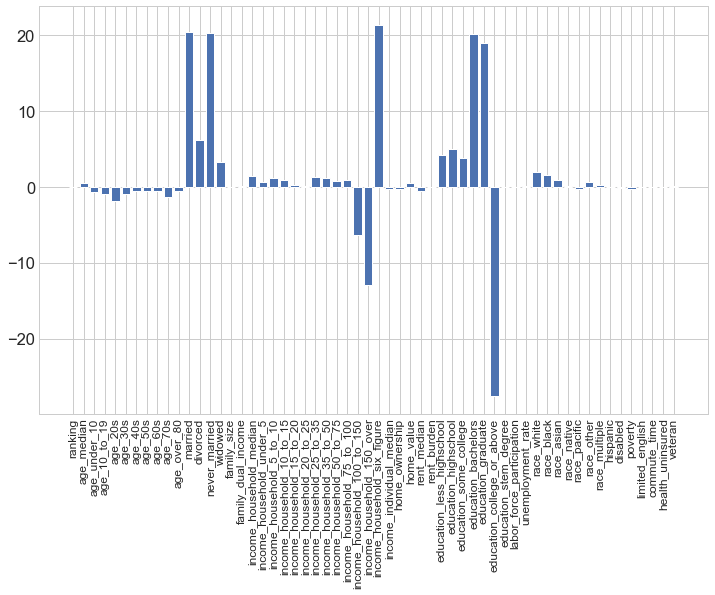

explained_variance:  0.3683
r2:  0.3647
MAE:  0.574
MSE:  0.6353
RMSE:  0.797
5x most influential SEDC features in terms of regression coefficient


SEDC feature  coefficient   coef_abs
40   education_college_or_above   -27.533085  27.533085
29  income_household_six_figure    21.364775  21.364775
11                      married    20.392471  20.392471
13                never_married    20.284897  20.284897
38          education_bachelors    20.122443  20.122443

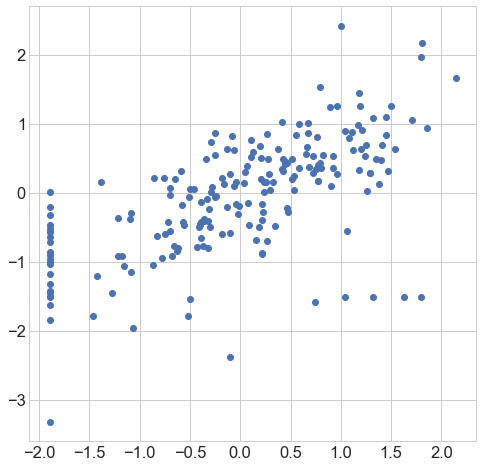

In [47]:
temp = pd.concat([city_df[SEDC_features_all], (np.log(1+df['bicycle_parking_count_pmn']))], axis=1)
temp = temp.fillna(temp.median())
feats = [i for i in temp.iloc[:,:-1].columns]

scaler = StandardScaler()
t_scaled = scaler.fit_transform(temp.values)

X = t_scaled[:,:-1]
y = t_scaled[:,-1]

reg = TheilSenRegressor().fit(X, y)
score = reg.score(X, y)
print("R-squared: ", round(reg.score(X, y),5))

reg.coef_

importance = reg.coef_ # summarize feature importance
for i in range(len(feats)):
    print(feats[i]+':  '+str(round(importance[i],5)))

plt.figure(figsize=(12,7.5)) # plot feature importance
plt.bar([feats[i] for i in range(len(importance))], importance)
plt.xticks(rotation=90, fontsize=12)
plt.show()

y_pred = reg.predict(X) # plot observed vs. predicted
plt.figure(figsize=(8,8))
plt.scatter(y, y_pred)

regression_results(y, y_pred)
accuracy_scores.append(['TheilSenRegressor', 'bicycle_parking_count_pmn_log', score])

print('5x most influential SEDC features in terms of regression coefficient')
importance_df = pd.DataFrame(list(zip(feats, list(importance))), columns=['SEDC feature', 'coefficient'])
importance_df['coef_abs'] = abs(importance_df['coefficient'])
importance_df.sort_values('coef_abs', ascending=False).head(5)

R-squared:  0.52258
ranking:  -0.10838
age_median:  1.32911
age_under_10:  0.08264
age_10_to_19:  -0.47702
age_20s:  -0.7481
age_30s:  -0.57155
age_40s:  -0.36118
age_50s:  -0.52071
age_60s:  -0.24315
age_70s:  -1.39717
age_over_80:  -0.2794
married:  19.631
divorced:  6.31631
never_married:  19.93273
widowed:  3.20024
family_size:  -0.20684
family_dual_income:  0.06293
income_household_median:  1.31095
income_household_under_5:  -0.3484
income_household_5_to_10:  -0.22849
income_household_10_to_15:  -0.27892
income_household_15_to_20:  -0.61859
income_household_20_to_25:  -0.89042
income_household_25_to_35:  -0.35784
income_household_35_to_50:  -0.19145
income_household_50_to_75:  -0.75012
income_household_75_to_100:  -0.40193
income_household_100_to_150:  -1.8174
income_household_150_over:  -4.67333
income_household_six_figure:  2.66311
income_individual_median:  -0.47609
home_ownership:  0.02677
home_value:  0.46788
rent_median:  -0.2985
rent_burden:  -0.06976
education_less_highsch

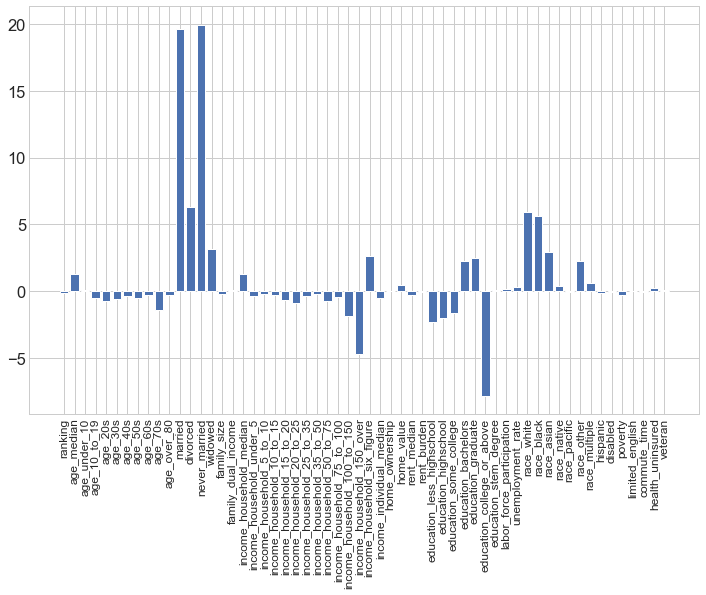

explained_variance:  0.5226
r2:  0.5226
MAE:  0.5156
MSE:  0.4774
RMSE:  0.691
5x most influential SEDC features in terms of regression coefficient


SEDC feature  coefficient   coef_abs
13               never_married    19.932730  19.932730
11                     married    19.631001  19.631001
40  education_college_or_above    -7.814233   7.814233
12                    divorced     6.316312   6.316312
44                  race_white     5.909722   5.909722

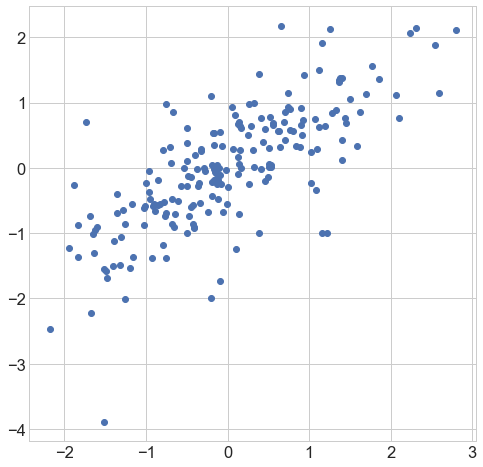

In [48]:
temp = pd.concat([city_df[SEDC_features_all], pd.Series(X_pca[:,0])], axis=1)
temp = temp.fillna(temp.median())
feats = [i for i in temp.iloc[:,:-1].columns]

scaler = StandardScaler()
t_scaled = scaler.fit_transform(temp.values)

X = t_scaled[:,:-1]
y = t_scaled[:,-1]

reg = TheilSenRegressor().fit(X, y)
score = reg.score(X, y)
print("R-squared: ", round(reg.score(X, y),5))

reg.coef_

importance = reg.coef_ # summarize feature importance
for i in range(len(feats)):
    print(feats[i]+':  '+str(round(importance[i],5)))

plt.figure(figsize=(12,7.5)) # plot feature importance
plt.bar([feats[i] for i in range(len(importance))], importance)
plt.xticks(rotation=90, fontsize=12)
plt.show()

y_pred = reg.predict(X) # plot observed vs. predicted
plt.figure(figsize=(8,8))
plt.scatter(y, y_pred)

regression_results(y, y_pred)
accuracy_scores.append(['TheilSenRegressor', 'PC1', score])

print('5x most influential SEDC features in terms of regression coefficient')
importance_df = pd.DataFrame(list(zip(feats, list(importance))), columns=['SEDC feature', 'coefficient'])
importance_df['coef_abs'] = abs(importance_df['coefficient'])
importance_df.sort_values('coef_abs', ascending=False).head(5)

### Poisson Regression on count data

This is GLM is used to predict a dependent variable that is comprised of discrete values. In this case the target variable used is the count of nodes per million persons, rounded to the nearest integer.

Number of samples with value of zero:  114
0.6773510026282308
ranking:  -0.07301
age_median:  -0.17733
age_under_10:  -0.44071
age_10_to_19:  -0.50033
age_20s:  -0.82666
age_30s:  -0.20952
age_40s:  0.20575
age_50s:  0.00029
age_60s:  0.54531
age_70s:  -1.22833
age_over_80:  -0.27827
married:  0.2348
divorced:  -0.49929
never_married:  0.03532
widowed:  -0.0609
family_size:  -0.03503
family_dual_income:  -0.17745
income_household_median:  0.16749
income_household_under_5:  -0.30586
income_household_5_to_10:  0.15247
income_household_10_to_15:  -0.03654
income_household_15_to_20:  -0.32158
income_household_20_to_25:  -0.43767
income_household_25_to_35:  0.54624
income_household_35_to_50:  0.03682
income_household_50_to_75:  -0.38938
income_household_75_to_100:  0.1791
income_household_100_to_150:  -0.096
income_household_150_over:  -0.99425
income_household_six_figure:  -0.63945
income_individual_median:  -0.39728
home_ownership:  -0.04504
home_value:  0.50154
rent_median:  -0.24976
ren

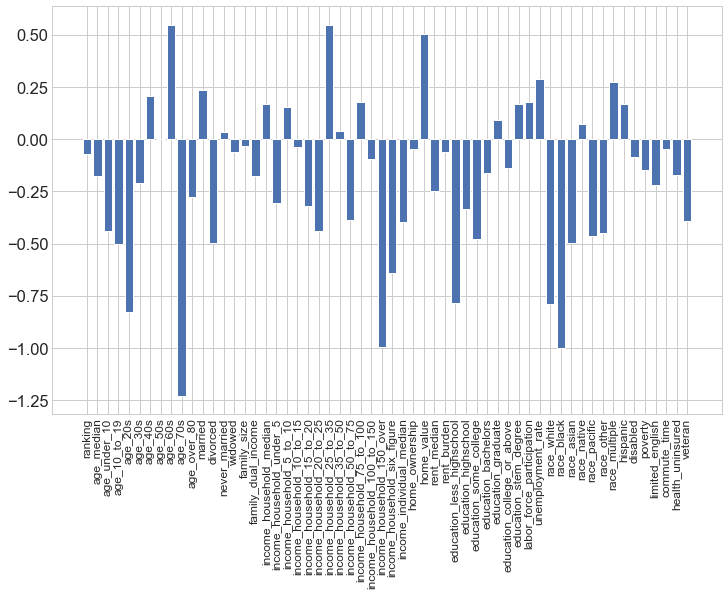

explained_variance:  0.7269
r2:  0.7269
MAE:  77.2399
MSE:  14940.6766
RMSE:  122.2321
5x most influential SEDC features in terms of regression coefficient


SEDC feature  coefficient  coef_abs
9                     age_70s    -1.228328  1.228328
45                 race_black    -1.002486  1.002486
28  income_household_150_over    -0.994251  0.994251
4                     age_20s    -0.826658  0.826658
44                 race_white    -0.791433  0.791433

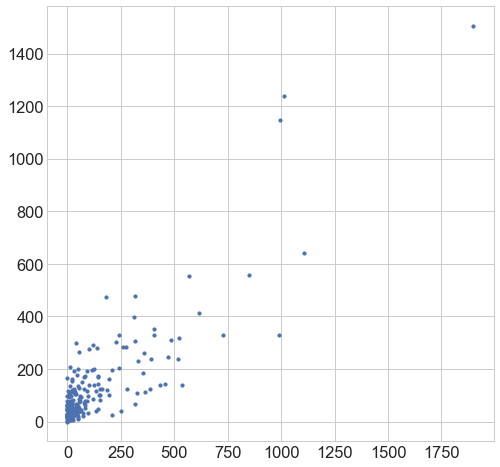

In [49]:
## Poisson Regression on count data

print("Number of samples with value of zero: ", len([i for i in round(df['fitness_station_count_pmn'],0) if i==0]))

temp = pd.concat([city_df[SEDC_features_all], (round(df['bicycle_parking_count_pmn'],0))], axis=1)
temp = temp.fillna(temp.median())
feats = [i for i in temp.iloc[:,:-1].columns]

scaler = StandardScaler()
t_scaled = scaler.fit_transform(temp.iloc[:,:-1].values)

X = t_scaled
y = temp.iloc[:,-1].values

reg = PoissonRegressor( max_iter=500).fit(X, y)
score = reg.score(X, y)
print(reg.score(X, y))

importance = reg.coef_
for i in range(len(feats)): # summarize feature importance
    print(feats[i]+':  '+str(round(importance[i],5)))

plt.figure(figsize=(12,7.5)) # plot feature importance
plt.bar([feats[i] for i in range(len(importance))], importance)
plt.xticks(rotation=90, fontsize=12)
plt.show()

y_pred = reg.predict(X)
plt.figure(figsize=(8,8))
plt.scatter(y, y_pred, s=10)

regression_results(y, y_pred)
accuracy_scores.append(['PoissonRegressor', 'bicycle_parking_count', score])

print('5x most influential SEDC features in terms of regression coefficient')
importance_df = pd.DataFrame(list(zip(feats, list(importance))), columns=['SEDC feature', 'coefficient'])
importance_df['coef_abs'] = abs(importance_df['coefficient'])
importance_df.sort_values('coef_abs', ascending=False).head(5)

In [50]:
pd.DataFrame(accuracy_scores).rename(columns={0:'Model', 1:'y', 2:'score'}).sort_values('score', ascending=False)

Model                              y     score
4   PoissonRegressor          bicycle_parking_count  0.677351
1   LinearRegression                            PC1  0.663260
0   LinearRegression  bicycle_parking_count_pmn_log  0.637488
3  TheilSenRegressor                            PC1  0.522583
2  TheilSenRegressor  bicycle_parking_count_pmn_log  0.364715

#### Reflections on linear models

- Income & Education are clearly the most influential independent variables when using OLS
- Thiel-Sen (outlier robust) and Poisson (count data) regressions showed more importance to other SEDC features including race, marital status, age and others.
- Suggestions for future studies
    - wider scope, larger dataset, panel regression
    - additional sdg measures